In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.utils import *
from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *
import graph_tool.all as gt

/tmp/ipykernel_3524191/3056876262.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/albertl/.conda/envs/flywire-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_context("talk")

In [3]:
# >=5 syn threshold was applied to this data already
ver = 630
fdir = "data/connections.csv"
syn_table = pd.read_csv(fdir)

In [4]:
syn_table.head()

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940617895883,720575940625455247,LAL_L,4,ACH
1,720575940618110513,720575940628422555,PRW,1,GLUT
2,720575940628716926,720575940629731579,CRE_L,4,ACH
3,720575940619238582,720575940634854554,AVLP_R,35,ACH
4,720575940605781449,720575940626111619,SIP_L,1,GLUT


### 1. Graph Construction

In [5]:
# build index dictionary
cellids =  np.unique(syn_table[["pre_root_id", "post_root_id"]])
nid2cid = {i: cid for i, cid in enumerate(cellids)}
cid2nid = {cid: i for i, cid in enumerate(cellids)}

In [6]:
syn_table["pre_nid"] = pd.Series([cid2nid[cid] for cid in syn_table["pre_root_id"]], 
                                 index=syn_table.index)
syn_table["post_nid"] = pd.Series([cid2nid[cid] for cid in syn_table["post_root_id"]], 
                                 index=syn_table.index)

In [7]:
edge_list = [(e[0], e[1], e[2], e[3]) for e in 
             syn_table[["pre_nid", "post_nid", "neuropil", "syn_count"]].values]

In [8]:
g_multi = gt.Graph()
g_multi.add_vertex(len(cellids))
e_neuropil = g_multi.new_ep("string")
e_syn_count = g_multi.new_ep("int32_t")
g_multi.add_edge_list(edge_list, eprops=[e_neuropil, e_syn_count])
g_multi.vp["cellid"] = g_multi.new_vp("int64_t")
g_multi.vp["cellid"].a = cellids
g_multi.ep["neuropil"] = e_neuropil
g_multi.ep["syn_count"] = e_syn_count

In [9]:
merged_syn_table = syn_table[["pre_nid", "post_nid", "syn_count"]
                           ].groupby(by=["pre_nid", "post_nid"]).sum().reset_index()

In [10]:
merged_edge_list = [(e[0], e[1], e[2]) for e in merged_syn_table.values]

In [11]:
g = gt.Graph()
g.add_vertex(len(cellids))
e_syn_count = g.new_ep("int32_t")
g.add_edge_list(merged_edge_list, eprops=[e_syn_count])
g.vp["cellid"] = g.new_vp("int64_t")
g.vp["cellid"].a = cellids
g.ep["syn_count"] = e_syn_count

In [12]:
# multi-graph
g_multi

<Graph object, directed, with 124891 vertices and 3793849 edges, 1 internal vertex property, 2 internal edge properties, at 0x15254da18ee0>

In [13]:
# merged weightedd graph
g

<Graph object, directed, with 124891 vertices and 2613112 edges, 1 internal vertex property, 1 internal edge property, at 0x1525338e92e0>

### 2. Synapse Distributions

In [14]:
all_regions = ["FB","EB","PB","NO","AMMC_L","AMMC_R","FLA_L","FLA_R",
               "CAN_L","CAN_R","PRW","SAD","GNG","AL_L","AL_R","LH_L","LH_R",
               "MB_CA_L","MB_CA_R","MB_PED_L","MB_PED_R","MB_VL_L","MB_VL_R","MB_ML_L",
               "MB_ML_R","BU_L","BU_R","GA_L","GA_R","LAL_L","LAL_R","SLP_L","SLP_R",
               "SIP_L","SIP_R","SMP_L","SMP_R","CRE_L","CRE_R","SCL_L","SCL_R","ICL_L","ICL_R",
               "IB_L","IB_R","ATL_L","ATL_R","VES_L","VES_R","EPA_L","EPA_R","GOR_L","GOR_R","SPS_L",
               "SPS_R","IPS_L","IPS_R","AOTU_L","AOTU_R","AVLP_L","AVLP_R","PVLP_L","PVLP_R","PLP_L","PLP_R",
               "WED_L","WED_R","ME_L","ME_R","AME_L","AME_R","LO_L","LO_R","LOP_L","LOP_R","LA_L","LA_R","OCG"]

In [15]:
np_order = ["FB","EB","PB","NO","AMMC_L","AMMC_R","FLA_L","FLA_R","CAN_L","CAN_R","PRW","SAD","GNG","AL_L","AL_R","LH_L","LH_R","MB_CA_L","MB_CA_R","MB_PED_L","MB_PED_R","MB_VL_L","MB_VL_R","MB_ML_L","MB_ML_R","BU_L","BU_R","GA_L","GA_R","LAL_L","LAL_R","SLP_L","SLP_R","SIP_L","SIP_R","SMP_L","SMP_R","CRE_L","CRE_R","SCL_L","SCL_R","ICL_L","ICL_R","IB_L","IB_R","ATL_L","ATL_R","VES_L","VES_R","EPA_L","EPA_R","GOR_L","GOR_R","SPS_L","SPS_R","IPS_L","IPS_R","AOTU_L","AOTU_R","AVLP_L","AVLP_R","PVLP_L","PVLP_R","PLP_L","PLP_R","WED_L","WED_R","ME_L","ME_R","AME_L","AME_R","LO_L","LO_R","LOP_L","LOP_R","LA_L","LA_R","OCG"]
np_names = ["FB","EB","PB","NO","AMMC(L)","AMMC(R)","FLA(L)","FLA(R)","CAN(L)","CAN(R)","PRW","SAD","GNG","AL(L)","AL(R)","LH(L)","LH(R)","MB-CA(L)","MB-CA(R)","MB-PED(L)","MB-PED(R)","MB-VL(L)","MB-VL(R)","MB-ML(L)","MB-ML(R)","BU(L)","BU(R)","GA(L)","GA(R)","LAL(L)","LAL(R)","SLP(L)","SLP(R)","SIP(L)","SIP(R)","SMP(L)","SMP(R)","CRE(L)","CRE(R)","SCL(L)","SCL(R)","ICL(L)","ICL(R)","IB(L)","IB(R)","ATL(L)","ATL(R)","VES(L)","VES(R)","EPA(L)","EPA(R)","GOR(L)","GOR(R)","SPS(L)","SPS(R)","IPS(L)","IPS(R)","AOTU(L)","AOTU(R)","AVLP(L)","AVLP(R)","PVLP(L)","PVLP(R)","PLP(L)","PLP(R)","WED(L)","WED(R)","ME(L)","ME(R)","AME(L)","AME(R)","LO(L)","LO(R)","LOP(L)","LOP(R)","LA(L)","LA(R)","OCG"]
np_color = ["#049a93","#10cac8","#36cfdc","#21adc4","#145ddc","#145ddc","#274bfe","#274bfe","#2081f2","#2081f2","#513bfe","#513bfe","#603ee4","#30d2fe","#30d2fe","#fe99b8","#fe99b8","#fe9e3f","#fe9e3f","#ffa88d","#ffa88d","#ffae79","#ffae79","#ff9e69","#ff9e69","#5479ef","#5479ef","#3d8ce2","#3d8ce2","#285bfa","#285bfa","#fed942","#fed942","#feb13a","#feb13a","#ffda59","#ffda59","#febd3b","#febd3b","#fdb95d","#fdb95d","#fbb256","#fbb256","#fe9e3e","#fe9e3e","#fead49","#fead49","#02dcc0","#02dcc0","#07c4ac","#07c4ac","#00b5d3","#00b5d3","#00957e","#00957e","#0dbfc2","#0dbfc2","#4c9efe","#4c9efe","#3d89fe","#3d89fe","#1a57ee","#1a57ee","#50bcfe","#50bcfe","#3b8dfe","#3b8dfe","#dd41d3","#dd41d3","#bc21a2","#bc21a2","#8a34d4","#8a34d4","#bc21a2","#bc21a2","#A21A78","#A21A78","#EA4BEA"]

/tmp/ipykernel_2691152/2552284339.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np_names, y=np_strength, palette=np_color)
/home/albertl/.conda/envs/flywire-env/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/albertl/.conda/envs/flywire-env/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/albertl/.conda/envs/flywire-env/lib/python3.9/si

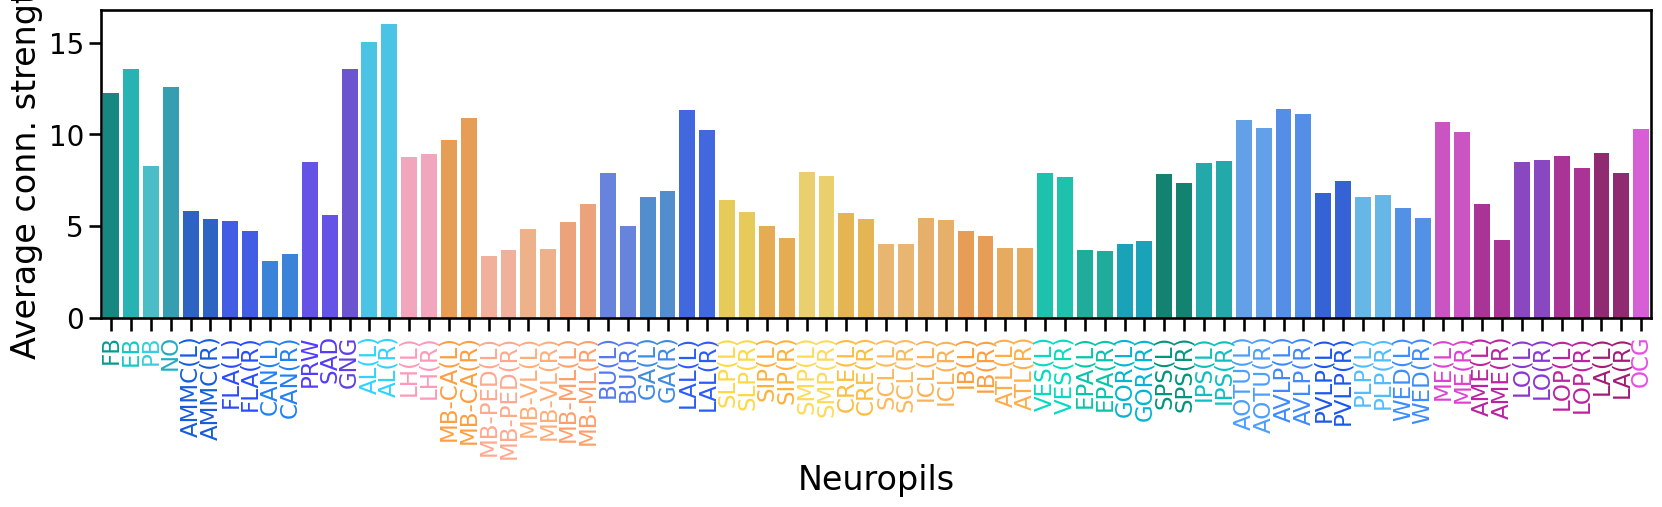

In [16]:
np_conn_cnt = syn_table[['syn_count','neuropil']][syn_table['neuropil']!="None"].groupby(by=['neuropil']).count().loc[np_order].values
np_conn_cnt = np_conn_cnt.reshape(-1)
np_sizes = syn_table[['syn_count','neuropil']][syn_table['neuropil']!="None"].groupby(by=['neuropil']).sum().loc[np_order].values
np_sizes = np_sizes.reshape(-1)

np_strength = np_sizes / np_conn_cnt
# best_fit_exp
fig, ax = plt.subplots(1,1,figsize=(20,4))
sns.barplot(x=np_names, y=np_strength, palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
# ax.set_yscale('log')
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("Average conn. strength", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
plt.savefig('figures/stats-{}/neuropil-avg-connection-strength.pdf'.format(ver), bbox_inches='tight')

### 3. Connected Components

In [20]:
# No autapse
np.unique(gt.label_self_loops(g).a)

PropertyArray([0], dtype=int32)

In [21]:
# Strongly Connected Components (SCCs)
sg_cmps, sg_cmp_hist = gt.label_components(g, directed=True)

In [22]:
print("top sizes of SCC:", np.sort(sg_cmp_hist)[::-1][:10])
print("number of SCC:", len(sg_cmp_hist))

top sizes of SCC: [115657      4      4      4      3      3      3      3      3      2]
number of SCC: 9164


In [23]:
# Weakly Connected Components (WCCs)
wg_cmps, wg_cmp_hist = gt.label_components(g, directed=False)

In [24]:
print("top sizes of WCC:", np.sort(wg_cmp_hist)[::-1][:10])
print("number of WCC:", len(wg_cmp_hist))

top sizes of WCC: [124778      7      7      7      7      6      6      5      5      4]
number of WCC: 35


### 4. Edge Percolation

In [45]:
# edges to be removed in a reversed order
edge_order_w_size = sorted([[e[0], e[1], e[2]] for e in g.get_edges([g.ep["syn_count"]])], 
                 key=lambda e: e[2])
edge_order = np.array(edge_order_w_size)[:,:2]
edge_size = np.array(edge_order_w_size)[:,2]

In [46]:
sizes, comp = gt.edge_percolation(g, edge_order)

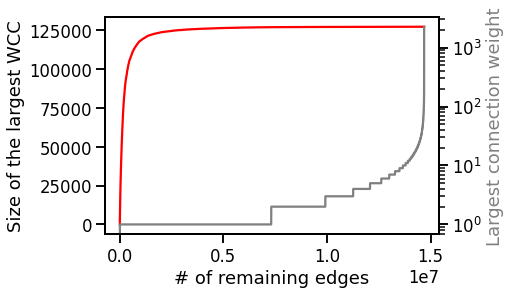

In [47]:
# edge percolation, removing strong connecions
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(sizes, 'red')
ax2.plot(np.insert(edge_size,0,0)[:len(sizes)], 'gray')
ax.set_ylabel("Size of the largest WCC")
ax2.set_ylabel("Largest connection weight", color='gray')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining edges")
plt.savefig('figures/stats-{}/remove-strong.pdf'.format(ver), bbox_inches='tight')

In [48]:
w_sizes, comp = gt.edge_percolation(g, edge_order[::-1])

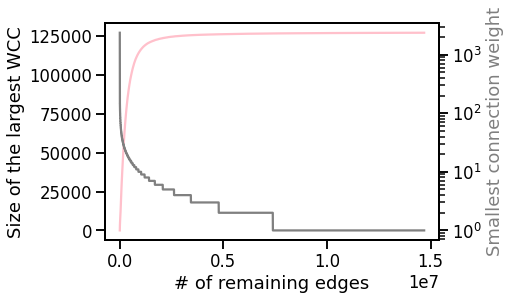

In [49]:
# edge percolation, removing weak connecions
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(w_sizes, 'pink')
ax2.plot(np.insert(edge_size,0,0)[::-1][:len(sizes)], 'gray')
ax.set_ylabel("Size of the largest WCC")
ax2.set_ylabel("Smallest connection weight", color='gray')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining edges")
plt.savefig('figures/stats-{}/remove-weak.pdf'.format(ver), bbox_inches='tight')

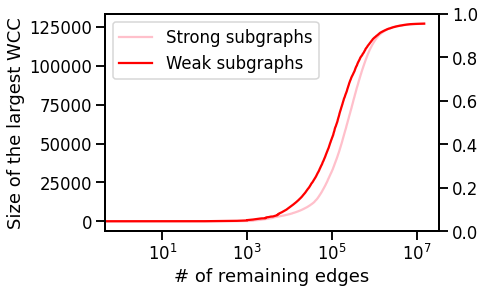

In [50]:
# edge percolation, removing strong connecions
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(w_sizes, 'pink', label='Strong subgraphs')
ax.plot(sizes, 'red', label='Weak subgraphs')
ax.set_xscale('log')
ax.set_ylabel("Size of the largest WCC")
ax.set_xlabel("# of remaining edges")
ax.legend()
plt.savefig('figures/stats-{}/strong-vs-weak.pdf'.format(ver), bbox_inches='tight')
plt.show()

In [17]:
scc1st = []
scc2nd = []
wcc1st = []
wcc2nd = []
edrec = []
clustering_coefs = []
densities = []
edrecER = []
s_ths = [1, 3, 5, 10, 15, 20, 30, 50]

for s_th in s_ths:
    strong_filter = g.new_edge_property("bool")
    strong_filter.a = (g.ep["syn_count"].a >= s_th)
    g.set_edge_filter(strong_filter)
    
    
    rec = gt.edge_reciprocity(g)
    edrec.append(rec)
    des = g.num_edges() / (g.num_vertices() * (g.num_vertices()-1))
    densities.append(des)
    edrecER.append(rec/des)
    clustering_coef = gt.global_clustering(g)[0]
    clustering_coefs.append(clustering_coef)
    
    sg_cmps, sg_cmp_hist = gt.label_components(g, directed=True)
    sg_size =  np.sort(sg_cmp_hist)[::-1][:2]
    scc1st.append(sg_size[0])
    scc2nd.append(sg_size[1])
    
    wg_cmps, wg_cmp_hist = gt.label_components(g, directed=False)
    wg_size =  np.sort(wg_cmp_hist)[::-1][:2]
    wcc1st.append(wg_size[0])
    wcc2nd.append(wg_size[1])
    
    g.clear_filters()

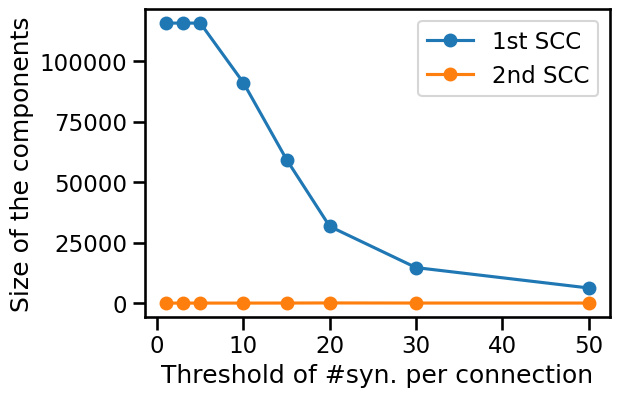

In [18]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(s_ths, scc1st, marker='o', label='1st SCC')
ax.plot(s_ths, scc2nd, marker='o', label='2nd SCC')
ax.set_ylabel("Size of the components")
ax.set_xlabel("Threshold of #syn. per connection")
ax.legend()
plt.savefig('figures/stats-{}/2nd-SCC.pdf'.format(ver), bbox_inches='tight')

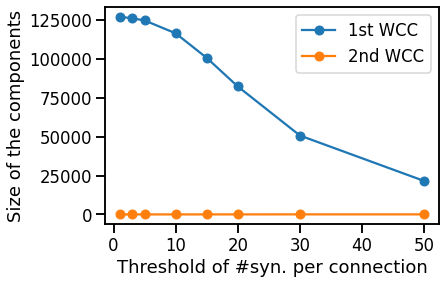

In [25]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(s_ths, wcc1st, marker='o', label='1st WCC')
ax.plot(s_ths, wcc2nd, marker='o', label='2nd WCC')
ax.set_ylabel("Size of the components")
ax.set_xlabel("Threshold of #syn. per connection")
ax.legend()
plt.savefig('figures/stats-{}/2nd-WCC.pdf'.format(ver), bbox_inches='tight')

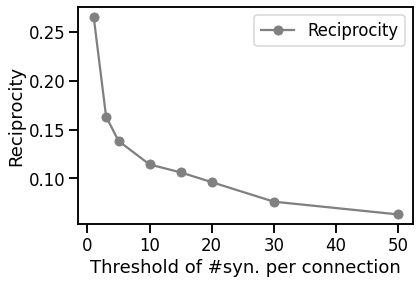

In [26]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(s_ths, edrec, marker='o', label='Reciprocity', color='gray')
ax.set_ylabel("Reciprocity")
ax.set_xlabel("Threshold of #syn. per connection")
ax.legend()
plt.savefig('figures/stats-{}/reciprocity-sweep.pdf'.format(ver), bbox_inches='tight')

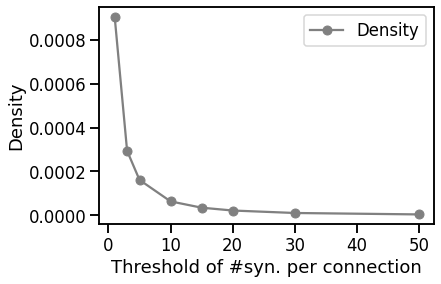

In [27]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(s_ths, densities, marker='o', label='Density', color='gray')
ax.set_ylabel("Density")
ax.set_xlabel("Threshold of #syn. per connection")
ax.legend()
plt.savefig('figures/stats-{}/density-sweep.pdf'.format(ver), bbox_inches='tight')

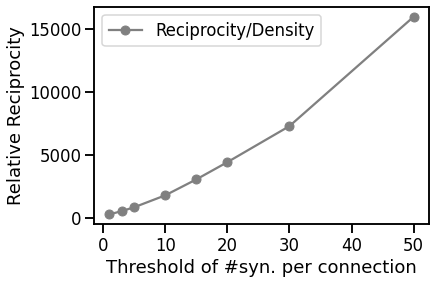

In [28]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(s_ths, edrecER, marker='o', label='Reciprocity/Density', color='gray')
ax.set_ylabel("Relative Reciprocity")
ax.set_xlabel("Threshold of #syn. per connection")
ax.legend()
plt.savefig('figures/stats-{}/relative-density-sweep.pdf'.format(ver), bbox_inches='tight')

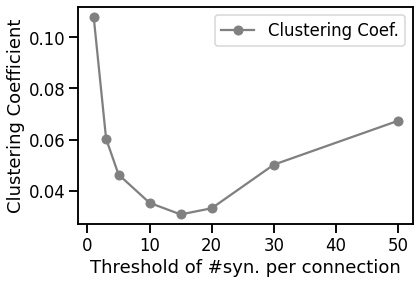

In [29]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(s_ths, clustering_coefs, marker='o', label='Clustering Coef.', color='gray')
ax.set_ylabel("Clustering Coefficient")
ax.set_xlabel("Threshold of #syn. per connection")
ax.legend()
plt.savefig('figures/stats-{}/clustering-sweep.pdf'.format(ver), bbox_inches='tight')

### 5. Vertex Percolation - WCC

In [17]:
vremove = sorted([v for v in g.vertices()], key=lambda v: v.out_degree())
vper_out_degrees = [v.out_degree() for v in vremove]
vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)
np.random.shuffle(vremove)
rand_vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
rand_vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)

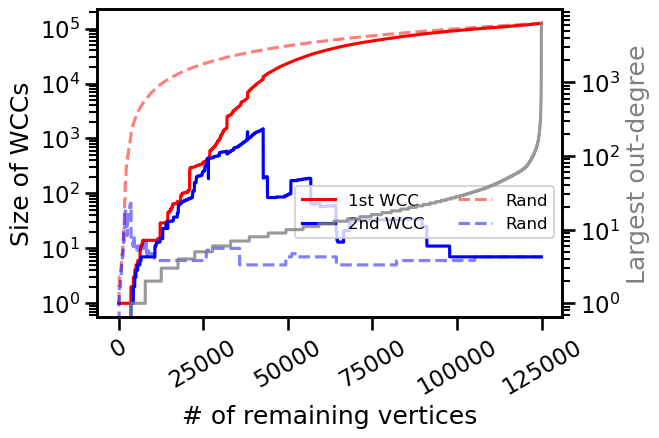

In [18]:
# edge percolation, removing vertices with large out degrees
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(vper_1st_sizes, 'red', label='1st WCC')
ax.plot(vper_2nd_sizes, 'blue', label='2nd WCC')
ax.plot(rand_vper_1st_sizes, 'red', linestyle='--', alpha=0.5, label='Rand')
ax.plot(rand_vper_2nd_sizes, 'blue', linestyle='--', alpha=0.5, label='Rand')
ax2.plot(vper_out_degrees, 'gray', alpha=0.8)
ax.set_ylabel("Size of WCCs")
ax2.set_ylabel("Largest out-degree", color='gray')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining vertices")
ax.tick_params(axis='x', rotation=30)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.23), ncol=2, fontsize=12)
plt.savefig('figures/stats-{}/remove-large-out.pdf'.format(ver), bbox_inches='tight')

In [27]:
vremove = sorted([v for v in g.vertices()], key=lambda v: -v.out_degree())
vper_out_degrees = [v.out_degree() for v in vremove]
vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)
np.random.shuffle(vremove)
rand_vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
rand_vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)

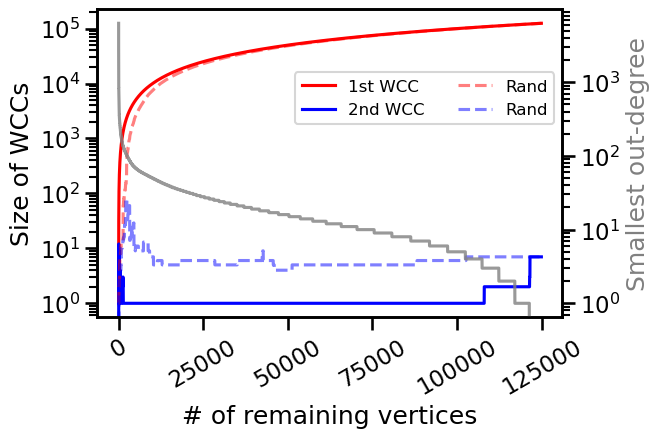

In [28]:
# edge percolation, removing vertices with small out degrees
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(vper_1st_sizes, 'red', label='1st WCC')
ax.plot(vper_2nd_sizes, 'blue', label='2nd WCC')
ax.plot(rand_vper_1st_sizes, 'red', linestyle='--', alpha=0.5, label='Rand')
ax.plot(rand_vper_2nd_sizes, 'blue', linestyle='--', alpha=0.5, label='Rand')
ax2.plot(vper_out_degrees, 'gray', alpha=0.8)
ax.set_ylabel("Size of WCCs")
ax2.set_ylabel("Smallest out-degree", color='gray')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining vertices")
ax.tick_params(axis='x', rotation=30)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.6), ncol=2, fontsize=12)
plt.savefig('figures/stats-{}/remove-small-out.pdf'.format(ver), bbox_inches='tight')

In [29]:
vremove = sorted([v for v in g.vertices()], key=lambda v: v.in_degree())
vper_in_degrees = [v.in_degree() for v in vremove]
vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)
np.random.shuffle(vremove)
rand_vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
rand_vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)

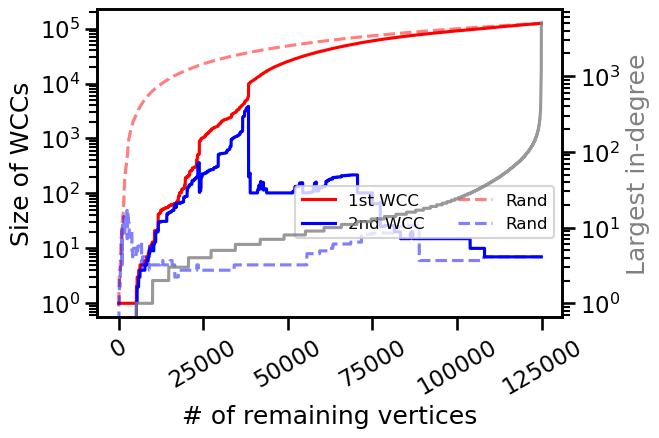

In [30]:
# edge percolation, removing vertices with large out degrees
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(vper_1st_sizes, 'red', label='1st WCC')
ax.plot(vper_2nd_sizes, 'blue', label='2nd WCC')
ax.plot(rand_vper_1st_sizes, 'red', linestyle='--', alpha=0.5, label='Rand')
ax.plot(rand_vper_2nd_sizes, 'blue', linestyle='--', alpha=0.5, label='Rand')
ax2.plot(vper_in_degrees, 'gray', alpha=0.8)
ax.set_ylabel("Size of WCCs")
ax2.set_ylabel("Largest in-degree", color='gray')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining vertices")
ax.tick_params(axis='x', rotation=30)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.23), ncol=2, fontsize=12)
plt.savefig('figures/stats-{}/remove-large-in.pdf'.format(ver), bbox_inches='tight')

In [31]:
vremove = sorted([v for v in g.vertices()], key=lambda v: -v.in_degree())
vper_in_degrees = [v.in_degree() for v in vremove]
vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)
np.random.shuffle(vremove)
rand_vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
rand_vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)

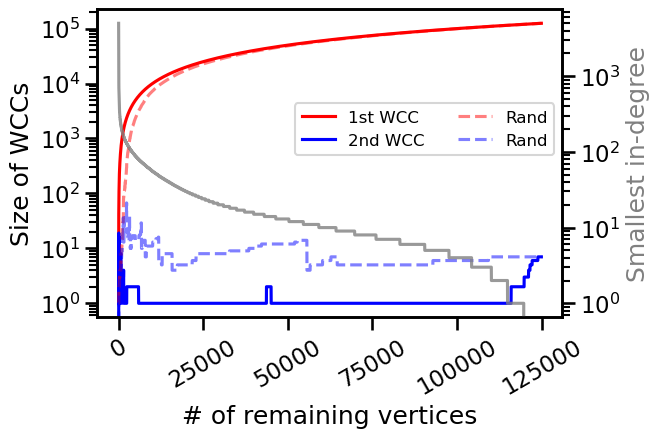

In [32]:
# edge percolation, removing vertices with large out degrees
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(vper_1st_sizes, 'red', label='1st WCC')
ax.plot(vper_2nd_sizes, 'blue', label='2nd WCC')
ax.plot(rand_vper_1st_sizes, 'red', linestyle='--', alpha=0.5, label='Rand')
ax.plot(rand_vper_2nd_sizes, 'blue', linestyle='--', alpha=0.5, label='Rand')
ax2.plot(vper_in_degrees, 'gray', alpha=0.8)
ax.set_ylabel("Size of WCCs")
ax2.set_ylabel("Smallest in-degree", color='gray')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining vertices")
ax.tick_params(axis='x', rotation=30)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.5), ncol=2, fontsize=12)
plt.savefig('figures/stats-{}/remove-small-in.pdf'.format(ver), bbox_inches='tight')

In [33]:
vremove = sorted([v for v in g.vertices()], key=lambda v: v.in_degree() + v.out_degree())
vper_total_degrees = [v.in_degree() + v.out_degree() for v in vremove]
vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)
np.random.shuffle(vremove)
rand_vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
rand_vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)

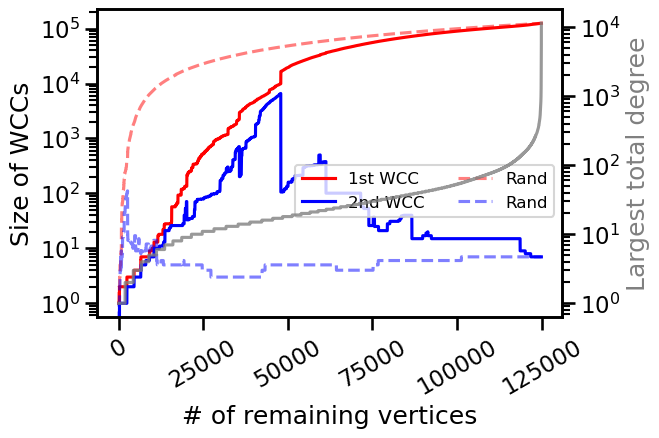

In [34]:
# edge percolation, removing vertices with large out degrees
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(vper_1st_sizes, 'red', label='1st WCC')
ax.plot(vper_2nd_sizes, 'blue', label='2nd WCC')
ax.plot(rand_vper_1st_sizes, 'red', linestyle='--', alpha=0.5, label='Rand')
ax.plot(rand_vper_2nd_sizes, 'blue', linestyle='--', alpha=0.5, label='Rand')
ax2.plot(vper_total_degrees, 'gray', alpha=0.8)
ax.set_ylabel("Size of WCCs")
ax2.set_ylabel("Largest total degree", color='gray')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining vertices")
ax.tick_params(axis='x', rotation=30)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.3), ncol=2, fontsize=12)
plt.savefig('figures/stats-{}/remove-large-total.pdf'.format(ver), bbox_inches='tight')

In [35]:
vremove = sorted([v for v in g.vertices()], key=lambda v: -v.in_degree()-v.out_degree())
vper_total_degrees = [v.in_degree()+v.out_degree() for v in vremove]
vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)
np.random.shuffle(vremove)
rand_vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
rand_vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)

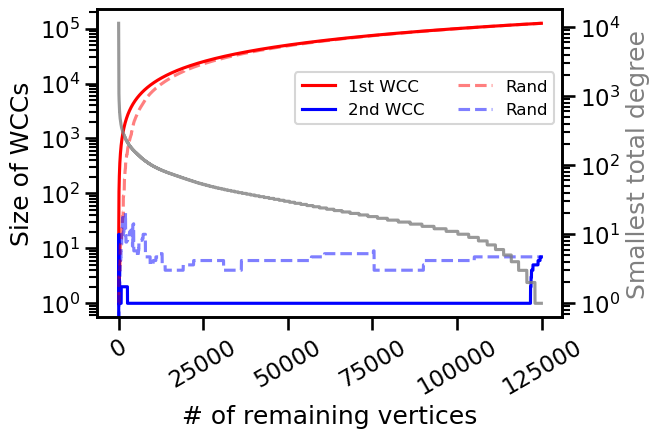

In [36]:
# edge percolation, removing vertices with large out degrees
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(vper_1st_sizes, 'red', label='1st WCC')
ax.plot(vper_2nd_sizes, 'blue', label='2nd WCC')
ax.plot(rand_vper_1st_sizes, 'red', linestyle='--', alpha=0.5, label='Rand')
ax.plot(rand_vper_2nd_sizes, 'blue', linestyle='--', alpha=0.5, label='Rand')
ax2.plot(vper_total_degrees, 'gray', alpha=0.8)
ax.set_ylabel("Size of WCCs")
ax2.set_ylabel("Smallest total degree", color='gray')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining vertices")
ax.tick_params(axis='x', rotation=30)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.6), ncol=2, fontsize=12)
plt.savefig('figures/stats-{}/remove-small-total.pdf'.format(ver), bbox_inches='tight')

### 6. Vertex Percolation - SCC

In [14]:
# down sampled 500x
# took 2 hr 6 min for one sample
#10000 took 17 hrs
# try 2500, 68 hrs expected

downsample_step = 2500
x = np.linspace(0, 124891, round(124891/downsample_step))

def get_top2_scc_sizes(g, vremove):
    scc1st, scc2nd = [], []
    for i in range(0, len(vremove), downsample_step):
        available_vertex = g.new_vertex_property("bool")
        available_vertex.a = np.isin(g.get_vertices(), vremove[:i+1])
        g.set_vertex_filter(available_vertex)
        sg_cmps, sg_cmp_hist = gt.label_components(g, directed=True)
        if len(sg_cmp_hist) > 1:
            res = np.sort(sg_cmp_hist)[::-1][:2]
            scc1st.append(res[0])
            scc2nd.append(res[1])
        else:
            res = np.sort(sg_cmp_hist)[::-1]
            scc1st.append(res[0])
            scc2nd.append(0)
        g.clear_filters()
    return scc1st, scc2nd

In [32]:
%%time

vremove = sorted([v for v in g.vertices()], key=lambda v: v.out_degree())
vper_out_degrees = [v.out_degree() for v in vremove]
vper_1st_sizes, vper_2nd_sizes = get_top2_scc_sizes(g, vremove)
np.random.shuffle(vremove)
rand_vper_1st_sizes, rand_vper_2nd_sizes = get_top2_scc_sizes(g, vremove)

CPU times: user 2d 19h 28min 7s, sys: 2.82 s, total: 2d 19h 28min 10s
Wall time: 2d 19h 46min 15s


In [34]:
x = np.linspace(0, 124891, round(124891/downsample_step))

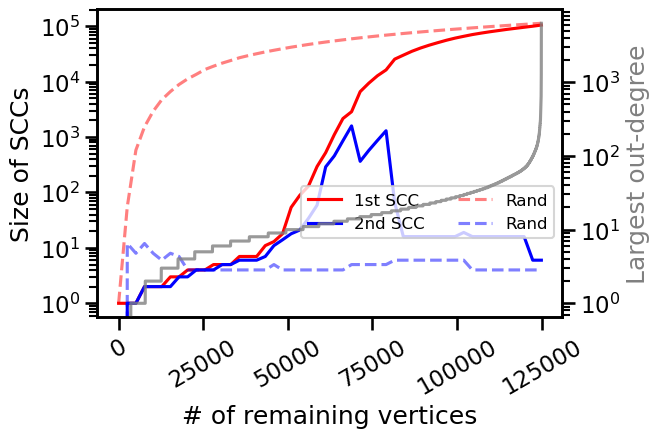

In [35]:
# edge percolation, removing vertices with large out degrees
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(x,vper_1st_sizes, 'red', label='1st SCC')
ax.plot(x,vper_2nd_sizes, 'blue', label='2nd SCC')
ax.plot(x,rand_vper_1st_sizes, 'red', linestyle='--', alpha=0.5, label='Rand')
ax.plot(x,rand_vper_2nd_sizes, 'blue', linestyle='--', alpha=0.5, label='Rand')
ax2.plot(vper_out_degrees, 'gray', alpha=0.8)
ax.set_ylabel("Size of SCCs")
ax2.set_ylabel("Largest out-degree", color='gray')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining vertices")
ax.tick_params(axis='x', rotation=30)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.23), ncol=2, fontsize=12)
plt.savefig('figures/stats-{}/remove-large-out-scc.pdf'.format(ver), bbox_inches='tight')

#check X axis, might have to add x labels
# tony wrote SCC version up to here

In [17]:
%%time

vremove = sorted([v for v in g.vertices()], key=lambda v: -v.out_degree())
vper_out_degrees = [v.out_degree() for v in vremove]
vper_1st_sizes, vper_2nd_sizes = get_top2_scc_sizes(g, vremove)
np.random.shuffle(vremove)
rand_vper_1st_sizes, rand_vper_2nd_sizes = get_top2_scc_sizes(g, vremove)

CPU times: user 2d 7h 41min 17s, sys: 17 s, total: 2d 7h 41min 34s
Wall time: 2d 7h 55min 33s


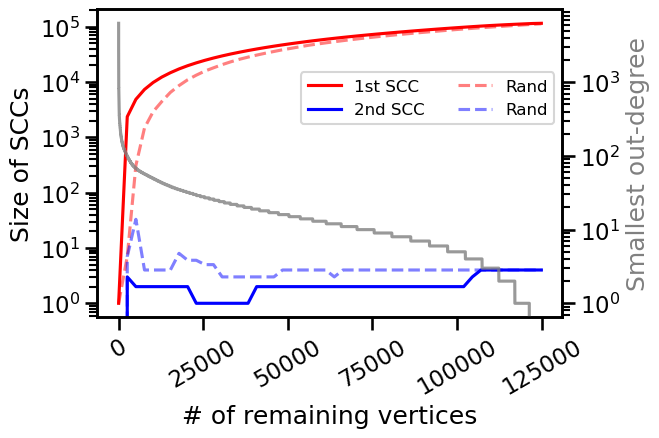

In [18]:
# edge percolation, removing vertices with small out degrees
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(x,vper_1st_sizes, 'red', label='1st SCC')
ax.plot(x,vper_2nd_sizes, 'blue', label='2nd SCC')
ax.plot(x,rand_vper_1st_sizes, 'red', linestyle='--', alpha=0.5, label='Rand')
ax.plot(x,rand_vper_2nd_sizes, 'blue', linestyle='--', alpha=0.5, label='Rand')
ax2.plot(vper_out_degrees, 'gray', alpha=0.8)
ax.set_ylabel("Size of SCCs")
ax2.set_ylabel("Smallest out-degree", color='gray')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining vertices")
ax.tick_params(axis='x', rotation=30)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.6), ncol=2, fontsize=12)
plt.savefig('figures/stats-{}/remove-small-out-scc.pdf'.format(ver), bbox_inches='tight')

In [15]:
%%time

vremove = sorted([v for v in g.vertices()], key=lambda v: v.in_degree())
vper_in_degrees = [v.in_degree() for v in vremove]
vper_1st_sizes, vper_2nd_sizes = get_top2_scc_sizes(g, vremove)
np.random.shuffle(vremove)
rand_vper_1st_sizes, rand_vper_2nd_sizes = get_top2_scc_sizes(g, vremove)

CPU times: user 2d 6h 53min 47s, sys: 3.34 s, total: 2d 6h 53min 50s
Wall time: 2d 7h 6min 27s


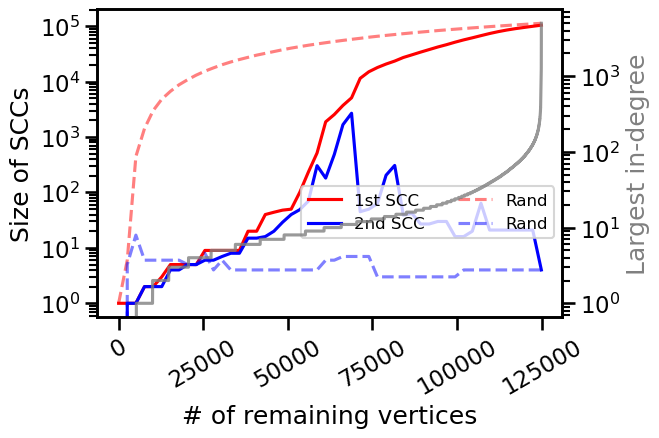

In [16]:
# edge percolation, removing vertices with large out degrees
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(x,vper_1st_sizes, 'red', label='1st SCC')
ax.plot(x,vper_2nd_sizes, 'blue', label='2nd SCC')
ax.plot(x,rand_vper_1st_sizes, 'red', linestyle='--', alpha=0.5, label='Rand')
ax.plot(x,rand_vper_2nd_sizes, 'blue', linestyle='--', alpha=0.5, label='Rand')
ax2.plot(vper_in_degrees, 'gray', alpha=0.8)
ax.set_ylabel("Size of SCCs")
ax2.set_ylabel("Largest in-degree", color='gray')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining vertices")
ax.tick_params(axis='x', rotation=30)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.23), ncol=2, fontsize=12)
plt.savefig('figures/stats-{}/remove-large-in-scc.pdf'.format(ver), bbox_inches='tight')

In [ ]:
%%time

vremove = sorted([v for v in g.vertices()], key=lambda v: -v.in_degree())
vper_in_degrees = [v.in_degree() for v in vremove]
vper_1st_sizes, vper_2nd_sizes = get_top2_scc_sizes(g, vremove)
np.random.shuffle(vremove)
rand_vper_1st_sizes, rand_vper_2nd_sizes = get_top2_scc_sizes(g, vremove)

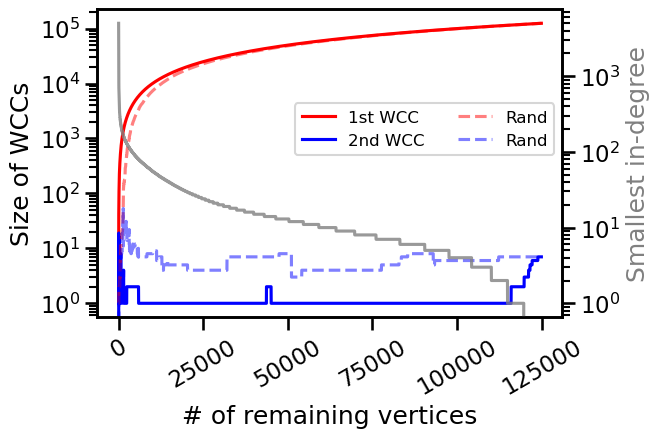

In [ ]:
# edge percolation, removing vertices with large out degrees
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(x,vper_1st_sizes, 'red', label='1st SCC')
ax.plot(x,vper_2nd_sizes, 'blue', label='2nd SCC')
ax.plot(x,rand_vper_1st_sizes, 'red', linestyle='--', alpha=0.5, label='Rand')
ax.plot(x,rand_vper_2nd_sizes, 'blue', linestyle='--', alpha=0.5, label='Rand')
ax2.plot(vper_in_degrees, 'gray', alpha=0.8)
ax.set_ylabel("Size of SCCs")
ax2.set_ylabel("Smallest in-degree", color='gray')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining vertices")
ax.tick_params(axis='x', rotation=30)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.5), ncol=2, fontsize=12)
plt.savefig('figures/stats-{}/remove-small-in-scc.pdf'.format(ver), bbox_inches='tight')

In [ ]:
%%time

vremove = sorted([v for v in g.vertices()], key=lambda v: v.in_degree() + v.out_degree())
vper_total_degrees = [v.in_degree() + v.out_degree() for v in vremove]
vper_1st_sizes, vper_2nd_sizes = get_top2_scc_sizes(g, vremove)
np.random.shuffle(vremove)
rand_vper_1st_sizes, rand_vper_2nd_sizes = get_top2_scc_sizes(g, vremove)

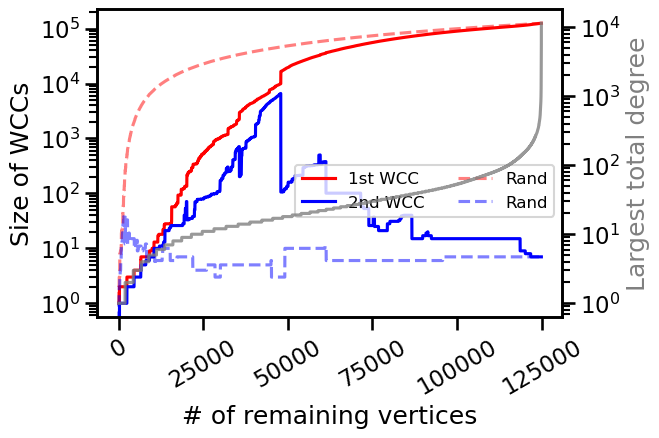

In [ ]:
# edge percolation, removing vertices with large out degrees
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(x,vper_1st_sizes, 'red', label='1st SCC')
ax.plot(x,vper_2nd_sizes, 'blue', label='2nd SCC')
ax.plot(x,rand_vper_1st_sizes, 'red', linestyle='--', alpha=0.5, label='Rand')
ax.plot(x,rand_vper_2nd_sizes, 'blue', linestyle='--', alpha=0.5, label='Rand')
ax2.plot(vper_total_degrees, 'gray', alpha=0.8)
ax.set_ylabel("Size of WCCs")
ax2.set_ylabel("Largest total degree", color='gray')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining vertices")
ax.tick_params(axis='x', rotation=30)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.3), ncol=2, fontsize=12)
plt.savefig('figures/stats-{}/remove-large-total-scc.pdf'.format(ver), bbox_inches='tight')

In [ ]:
%%time

vremove = sorted([v for v in g.vertices()], key=lambda v: -v.in_degree()-v.out_degree())
vper_total_degrees = [v.in_degree()+v.out_degree() for v in vremove]
vper_1st_sizes, vper_2nd_sizes = get_top2_scc_sizes(g, vremove)
np.random.shuffle(vremove)
rand_vper_1st_sizes, rand_vper_2nd_sizes = get_top2_scc_sizes(g, vremove)

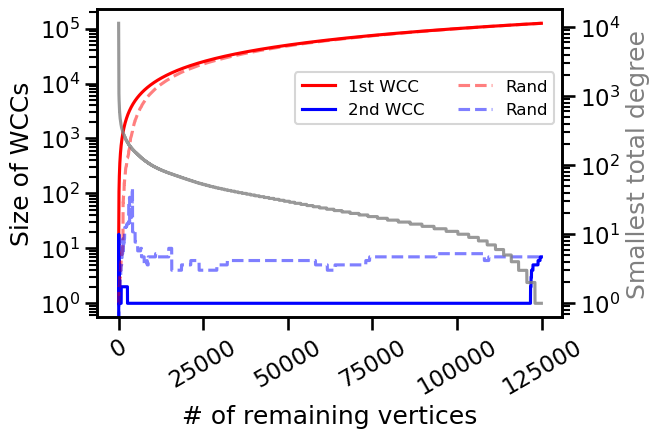

In [ ]:
# edge percolation, removing vertices with large out degrees
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(x,vper_1st_sizes, 'red', label='1st SCC')
ax.plot(x,vper_2nd_sizes, 'blue', label='2nd SCC')
ax.plot(x,rand_vper_1st_sizes, 'red', linestyle='--', alpha=0.5, label='Rand')
ax.plot(x,rand_vper_2nd_sizes, 'blue', linestyle='--', alpha=0.5, label='Rand')
ax2.plot(vper_total_degrees, 'gray', alpha=0.8)
ax.set_ylabel("Size of SCCs")
ax2.set_ylabel("Smallest total degree", color='gray')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining vertices")
ax.tick_params(axis='x', rotation=30)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.6), ncol=2, fontsize=12)
plt.savefig('figures/stats-{}/remove-small-total-scc.pdf'.format(ver), bbox_inches='tight')

### 6 Smilkov & Kocarev - directed rich club

In [14]:
rich_club_coefficients = {}
rich_club_coefficients_null = {}

In [15]:
%%time
degrees = g.degree_property_map("in") 

# Compute the maximum degree in the graph
max_degree = int(np.max(degrees.a))

# Create a list to store the rich club coefficients
rich_club_coefficients["in"] = []

# Compute the rich club coefficients for each value of k
for k in range(1, max_degree + 1):
    subgraph = gt.GraphView(g, vfilt=(degrees.a >= k))
    m = subgraph.num_edges()
    nk = subgraph.num_vertices()
    if m > 0:
        k_edges = (nk * (nk - 1))
        rich_club_coefficients["in"].append(m / k_edges)
    else:
        rich_club_coefficients["in"].append(0)

CPU times: user 10min 56s, sys: 344 ms, total: 10min 56s
Wall time: 10min 56s


In [16]:
rich_club_coefficients_nulls = {}

In [17]:
rich_club_coefficients_nulls["in"] = []

In [ ]:
%%time
# Generate a random null model for each value of k
N_REPEAT = 5

g_rand = gt.Graph(g)
for repeat in range(N_REPEAT):
    res = []
    ret = gt.random_rewire(g_rand, "configuration", n_iter=10)
    in_degrees = g_rand.degree_property_map("in")  
    max_degree = int(np.max(in_degrees.a))

    for k in range(1, max_degree + 1):
        subgraph = gt.GraphView(g_rand, vfilt=(in_degrees.a >= k))
        m_rand = subgraph.num_edges()
        if m_rand > 0:
            nk = subgraph.num_vertices()
            if m_rand > 0:
                k_edges_rand = (nk * (nk - 1))
                res.append(m_rand / k_edges_rand)
            else:
                res.append(0)
        else:
            res.append(0)
            
    rich_club_coefficients_nulls["in"].append(res)

In [ ]:
import pickle

with open('saved/630-rich-club-in-cfg.pickle', 'wb') as handle:
    pickle.dump(rich_club_coefficients_nulls["in"], handle, protocol=pickle.HIGHEST_PROTOCOL)

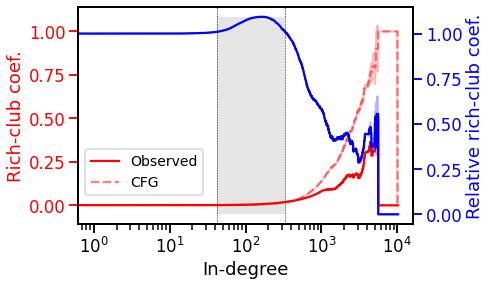

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(rich_club_coefficients["in"], color='red', label="Observed")
ax.plot(np.mean(rich_club_coefficients_nulls["in"], axis=0), linestyle="--", color='red', alpha=0.5, label="CFG")

# Calculate mean and standard deviation
mean = np.mean(rich_club_coefficients_nulls["in"], axis=0)
std = np.std(rich_club_coefficients_nulls["in"], axis=0)

# Plot mean with shadow
ax.fill_between(range(len(mean)), mean - std, mean + std, color='red', alpha=0.2)

ax.set_xlabel("In-degree")
ax.set_xscale('log')
ax.tick_params(axis='y', colors='red')
ax.set_ylabel("Rich-club coef.", color='red')
plt.legend(loc="lower left", bbox_to_anchor=(0.0, 0.1), fontsize=14)

ax2 = ax.twinx()

# Calculate relative rich-club coefficients with standard deviation
relative_rc = np.divide(np.array(rich_club_coefficients["in"]), mean, out=np.zeros_like(mean), where=mean != 0)
relative_rc_std = np.std([np.divide(np.array(rich_club_coefficients["in"]), rich_club_coefficients_nulls["in"][i], 
                      out=np.zeros_like(mean), where=mean != 0) for i in range(5)], axis=0)

ax2.plot(relative_rc, color='blue')
ax2.fill_between(range(len(relative_rc)), relative_rc - relative_rc_std, relative_rc + relative_rc_std, color='blue', alpha=0.2)

ax2.tick_params(axis='y', colors='blue')
ax2.set_ylabel("Relative rich-club coef.", color='blue')

# Add vertical dashed lines where relative_rc > 1
sig_range = np.arange(len(relative_rc))[relative_rc > 1.01]
ax.axvline(sig_range.min(), color='black', linestyle='--', linewidth=0.5)
ax.axvline(sig_range.max(), color='black', linestyle='--', linewidth=0.5)

# Fill the region between the vertical lines with transparent gray
ax.fill_betweenx(ax.get_ylim(), sig_range.min(), sig_range.max(), facecolor='gray', alpha=0.2, edgecolor=None)

plt.savefig('figures/stats-{}/rich-club-in-arbitary.pdf'.format(ver), bbox_inches='tight')

In [22]:
sig_range

array([ 42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
       198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
       211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [23]:
%%time
degrees = g.degree_property_map("out") 

# Compute the maximum degree in the graph
max_degree = int(np.max(degrees.a))

# Create a list to store the rich club coefficients
rich_club_coefficients["out"] = []

# Compute the rich club coefficients for each value of k
for k in range(1, max_degree + 1):
    subgraph = gt.GraphView(g, vfilt=(degrees.a >= k))
    m = subgraph.num_edges()
    nk = subgraph.num_vertices()
    if m > 0:
        k_edges = (nk * (nk - 1))
        rich_club_coefficients["out"].append(m / k_edges)
    else:
        rich_club_coefficients["out"].append(0)

CPU times: user 10min 19s, sys: 596 ms, total: 10min 19s
Wall time: 10min 26s


In [24]:
rich_club_coefficients_nulls["out"] = []

In [25]:
%%time
# Generate a random null model for each value of k

g_rand = gt.Graph(g)
for repeat in range(5):
    res = []
    ret = gt.random_rewire(g_rand, "configuration", n_iter=10)
    out_degrees = g_rand.degree_property_map("out")  
    max_degree = int(np.max(out_degrees.a))

    for k in range(1, max_degree + 1):
        subgraph = gt.GraphView(g_rand, vfilt=(out_degrees.a >= k))
        m_rand = subgraph.num_edges()
        if m_rand > 0:
            nk = subgraph.num_vertices()
            if m_rand > 0:
                k_edges_rand = (nk * (nk - 1))
                res.append(m_rand / k_edges_rand)
            else:
                res.append(0)
        else:
            res.append(0)
            
    rich_club_coefficients_nulls["out"].append(res)

CPU times: user 1h 15min 18s, sys: 1min 38s, total: 1h 16min 57s
Wall time: 1h 25min


In [26]:
import pickle

with open('saved/630-rich-club-out-cfg.pickle', 'wb') as handle:
    pickle.dump(rich_club_coefficients_nulls["out"], handle, protocol=pickle.HIGHEST_PROTOCOL)

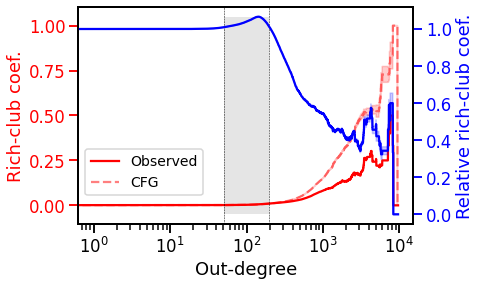

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(rich_club_coefficients["out"], color='red', label="Observed")
ax.plot(np.mean(rich_club_coefficients_nulls["out"], axis=0), linestyle="--", color='red', alpha=0.5, label="CFG")

# Calculate mean and standard deviation
mean = np.mean(rich_club_coefficients_nulls["out"], axis=0)
std = np.std(rich_club_coefficients_nulls["out"], axis=0)

# Plot mean with shadow
ax.fill_between(range(len(mean)), mean - std, mean + std, color='red', alpha=0.2)

ax.set_xlabel("Out-degree")
ax.set_xscale('log')
ax.tick_params(axis='y', colors='red')
ax.set_ylabel("Rich-club coef.", color='red')
plt.legend(loc="lower left", bbox_to_anchor=(0.0, 0.1), fontsize=14)

ax2 = ax.twinx()

# Calculate relative rich-club coefficients with standard deviation
relative_rc = np.divide(np.array(rich_club_coefficients["out"]), mean, out=np.zeros_like(mean), where=mean != 0)
relative_rc_std = np.std([np.divide(np.array(rich_club_coefficients["out"]), rich_club_coefficients_nulls["out"][i], 
                      out=np.zeros_like(mean), where=mean != 0) for i in range(5)], axis=0)

ax2.plot(relative_rc, color='blue')
ax2.fill_between(range(len(relative_rc)), relative_rc - relative_rc_std, relative_rc + relative_rc_std, color='blue', alpha=0.2)

ax2.tick_params(axis='y', colors='blue')
ax2.set_ylabel("Relative rich-club coef.", color='blue')

# Add vertical dashed lines where relative_rc > 1
sig_range = np.arange(len(relative_rc))[relative_rc > 1.01]
ax.axvline(sig_range.min(), color='black', linestyle='--', linewidth=0.5)
ax.axvline(sig_range.max(), color='black', linestyle='--', linewidth=0.5)

# Fill the region between the vertical lines with transparent gray
ax.fill_betweenx(ax.get_ylim(), sig_range.min(), sig_range.max(), facecolor='gray', alpha=0.2, edgecolor=None)

plt.savefig('figures/stats-{}/rich-club-out-arbitary.pdf'.format(ver), bbox_inches='tight')

In [29]:
sig_range

array([ 51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199])

In [33]:
%%time
in_degrees = g.degree_property_map("in") 
out_degrees = g.degree_property_map("out") 

# Compute the maximum degree in the graph
max_degree = int(np.max(in_degrees.a + out_degrees.a))

# Create a list to store the rich club coefficients
rich_club_coefficients["total"] = []

# Compute the rich club coefficients for each value of k
for k in range(1, max_degree + 1):
    subgraph = gt.GraphView(g, vfilt=(in_degrees.a + out_degrees.a >= k))
    m = subgraph.num_edges()
    nk = subgraph.num_vertices()
    if m > 0:
        k_edges = (nk * (nk - 1))
        rich_club_coefficients["total"].append(m / k_edges)
    else:
        rich_club_coefficients["total"].append(0)

CPU times: user 20min 45s, sys: 1.45 s, total: 20min 46s
Wall time: 21min


In [40]:
# with open('saved/630-rich-club-total-abs.pickle', 'wb') as handle:
#     pickle.dump(rich_club_coefficients["total"], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
rich_club_coefficients_nulls = {}

In [42]:
rich_club_coefficients_nulls["total"] = []

In [43]:
%%time
# Generate a random null model for each value of k

g_rand = gt.Graph(g)
for repeat in range(5):
    res = []
    ret = gt.random_rewire(g_rand, "configuration", n_iter=10)
    in_degrees = g_rand.degree_property_map("in") 
    out_degrees = g_rand.degree_property_map("out") 
    max_degree = int(np.max(in_degrees.a + out_degrees.a))

    for k in range(1, max_degree + 1):
        subgraph = gt.GraphView(g_rand, vfilt=(in_degrees.a + out_degrees.a >= k))
        m_rand = subgraph.num_edges()
        if m_rand > 0:
            nk = subgraph.num_vertices()
            if m_rand > 0:
                k_edges_rand = (nk * (nk - 1))
                res.append(m_rand / k_edges_rand)
            else:
                res.append(0)
        else:
            res.append(0)
            
    rich_club_coefficients_nulls["total"].append(res)

CPU times: user 1h 55min 37s, sys: 46.6 s, total: 1h 56min 23s
Wall time: 1h 58min 37s


In [44]:
with open('saved/630-rich-club-total-cfg.pickle', 'wb') as handle:
    pickle.dump(rich_club_coefficients_nulls["total"], handle, protocol=pickle.HIGHEST_PROTOCOL)

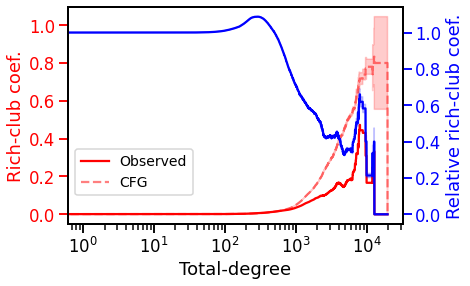

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(rich_club_coefficients["total"], color='red', label="Observed")
ax.plot(np.mean(rich_club_coefficients_nulls["total"], axis=0), linestyle="--", color='red', alpha=0.5, label="CFG")

# Calculate mean and standard deviation
mean = np.mean(rich_club_coefficients_nulls["total"], axis=0)
std = np.std(rich_club_coefficients_nulls["total"], axis=0)

# Plot mean with shadow
ax.fill_between(range(len(mean)), mean - std, mean + std, color='red', alpha=0.2)

ax.set_xlabel("Total-degree")
ax.set_xscale('log')
ax.tick_params(axis='y', colors='red')
ax.set_ylabel("Rich-club coef.", color='red')
plt.legend(loc="lower left", bbox_to_anchor=(0.0, 0.1), fontsize=14)

ax2 = ax.twinx()

# Calculate relative rich-club coefficients with standard deviation
relative_rc = np.divide(np.array(rich_club_coefficients["total"]), mean, out=np.zeros_like(mean), where=mean != 0)
relative_rc_std = np.std([np.divide(np.array(rich_club_coefficients["total"]), rich_club_coefficients_nulls["total"][i], 
                      out=np.zeros_like(mean), where=mean != 0) for i in range(5)], axis=0)

ax2.plot(relative_rc, color='blue')
ax2.fill_between(range(len(relative_rc)), relative_rc - relative_rc_std, relative_rc + relative_rc_std, color='blue', alpha=0.2)

ax2.tick_params(axis='y', colors='blue')
ax2.set_ylabel("Relative rich-club coef.", color='blue')

# Add vertical dashed lines where relative_rc > 1
for i, rc_value in enumerate(relative_rc-10*relative_rc_std > 1):
    if rc_value > 1:
        ax.axvline(i, color='black', linestyle='--', linewidth=0.5)
        break

plt.savefig('figures/stats-{}/rich-club-total.pdf'.format(ver), bbox_inches='tight')

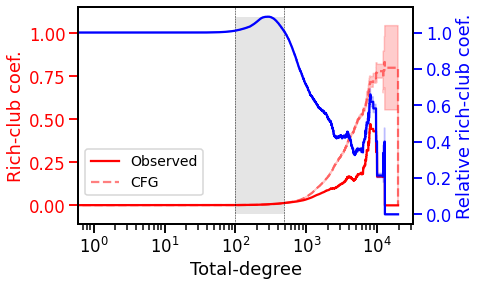

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(rich_club_coefficients["total"], color='red', label="Observed")
ax.plot(np.mean(rich_club_coefficients_nulls["total"], axis=0), linestyle="--", color='red', alpha=0.5, label="CFG")

# Calculate mean and standard deviation
mean = np.mean(rich_club_coefficients_nulls["total"], axis=0)
std = np.std(rich_club_coefficients_nulls["total"], axis=0)

# Plot mean with shadow
ax.fill_between(range(len(mean)), mean - std, mean + std, color='red', alpha=0.2)

ax.set_xlabel("Total-degree")
ax.set_xscale('log')
ax.tick_params(axis='y', colors='red')
ax.set_ylabel("Rich-club coef.", color='red')
plt.legend(loc="lower left", bbox_to_anchor=(0.0, 0.1), fontsize=14)

ax2 = ax.twinx()

# Calculate relative rich-club coefficients with standard deviation
relative_rc = np.divide(np.array(rich_club_coefficients["total"]), mean, out=np.zeros_like(mean), where=mean != 0)
relative_rc_std = np.std([np.divide(np.array(rich_club_coefficients["total"]), rich_club_coefficients_nulls["total"][i], 
                      out=np.zeros_like(mean), where=mean != 0) for i in range(5)], axis=0)

ax2.plot(relative_rc, color='blue')
ax2.fill_between(range(len(relative_rc)), relative_rc - relative_rc_std, relative_rc + relative_rc_std, color='blue', alpha=0.2)

ax2.tick_params(axis='y', colors='blue')
ax2.set_ylabel("Relative rich-club coef.", color='blue')

# Add vertical dashed lines where relative_rc > 1
sig_range = np.arange(len(relative_rc))[relative_rc > 1.01]
ax.axvline(sig_range.min(), color='black', linestyle='--', linewidth=0.5)
ax.axvline(sig_range.max(), color='black', linestyle='--', linewidth=0.5)

# Fill the region between the vertical lines with transparent gray
ax.fill_betweenx(ax.get_ylim(), sig_range.min(), sig_range.max(), facecolor='gray', alpha=0.2, edgecolor=None)

plt.savefig('figures/stats-{}/rich-club-total-arbitary.pdf'.format(ver), bbox_inches='tight')

In [49]:
in_degrees = g.degree_property_map("in") 
out_degrees = g.degree_property_map("out") 
rich_subgraph = gt.GraphView(g, vfilt=(in_degrees.a + out_degrees.a <= 60))

In [50]:
rich_subgraph = gt.Graph(rich_subgraph, prune=True)
rich_subgraph

<Graph object, directed, with 16091 vertices and 35171 edges, 1 internal vertex property, 1 internal edge property, at 0x7f80fca96048>

In [51]:
# Weakly Connected Components (WCCs)
rwg_cmps, rwg_cmp_hist = gt.label_components(rich_subgraph, directed=False)

In [52]:
print("top sizes of WCC:", np.sort(rwg_cmp_hist)[::-1][:10])
print("number of WCC:", len(rwg_cmp_hist))

top sizes of WCC: [4288 4199  715  688  570  504  286  264  127   56]
number of WCC: 2369


In [63]:
np.sum(rwg_cmps.a==4),np.sum(rwg_cmps.a==0)

(PropertyArray(4199), PropertyArray(4288))

In [65]:
pd.DataFrame(np.array(rich_subgraph.vp["cellid"].a[rwg_cmps.a==0])).to_csv("low_degree_group_1.csv")
pd.DataFrame(np.array(rich_subgraph.vp["cellid"].a[rwg_cmps.a==4])).to_csv("low_degree_group_2.csv")

In [67]:
rich_subgraph.vp["cellid"].a[rwg_cmps.a==4][:20]

PropertyArray([720575940602880736, 720575940603356896, 720575940603435232,
               720575940603505068, 720575940603718316, 720575940603940012,
               720575940604377312, 720575940604515360, 720575940604572606,
               720575940604650464, 720575940604668094, 720575940604747953,
               720575940604872416, 720575940604873406, 720575940604958142,
               720575940604969161, 720575940604995296, 720575940605032364,
               720575940605074144, 720575940605077449])

In [68]:
in_degrees = g.degree_property_map("in") 
out_degrees = g.degree_property_map("out") 

# Create a list to store the rich club coefficients
rich_club_coefficients["total"] = []

gt.GraphView(g, vfilt=(in_degrees.a + out_degrees.a >= 98))

<GraphView object, directed, with 94277 vertices and 13007067 edges, 1 internal vertex property, 1 internal edge property, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f80fca906a0, at 0x7f80fc988470>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f80fca906a0, at 0x7f80fc988358>, False), at 0x7f80fca906a0>

In [76]:
sum(g.get_total_degrees(g.get_vertices()) >= 98)

94277

### 6. Recurrence (Reciprocity)

In [95]:
# bidirectional edges / total edges
reciprocity = gt.edge_reciprocity(g)
print("edge reciprocity:", reciprocity)

edge reciprocity: 0.26509494315094073


In [96]:
# connection probability
p_conn = g.num_edges() / (g.num_vertices() * (g.num_vertices()-1))
print("connection probability:", p_conn)

connection probability: 0.0009824362924526838


In [40]:
# overrepresentation to ER
(reciprocity * p_conn) / (p_conn * p_conn)

700.9490661911755

In [43]:
merged_edge_list_th5 = [e for e in merged_edge_list if e[2] >= 5]

In [44]:
cfg_th5 = gt.Graph()
cfg_th5.add_vertex(len(cellids))
cfg_th5.add_edge_list(merged_edge_list_th5)

In [35]:
%%time
# this block takes long time (~15min for 100 samples)
cfg_rec_th5 = []
for _ in range(100):
    gt.random_rewire(cfg_th5)
    cfg_rec_th5.append(gt.edge_reciprocity(cfg_th5))

CPU times: user 1h 10min 47s, sys: 3min 6s, total: 1h 13min 53s
Wall time: 46min 49s


In [36]:
np.mean(cfg_rec_th5)

0.006261701075465626

In [61]:
reciprocity_th5 / np.mean(cfg_rec_th5)

37.86140689514119

In [43]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(x=s_ths, y=edrecER, marker='o', color='g')
ax.set_ylabel("Relative reciprocity to ER")
ax.set_xlabel("Threshold of #syn. per connection")
plt.savefig('figures/stats-{}/reciprocity-er.pdf'.format(ver), bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(s_ths, edrec, marker='o', color='teal')
ax2 = ax.twinx()
ax2.plot(s_ths, densities, marker='o', color='red', alpha=0.4)
ax.set_ylabel("Edge reciprocity", color='teal')
ax2.set_ylabel("Density", color='red', alpha=0.6)
ax.set_xlabel("Threshold of #syn. per connection")
plt.savefig('figures/stats-{}/reciprocity-vs-density.pdf'.format(ver), bbox_inches='tight')

### 7. Hemibrain Specificity

In [99]:
optic_lobe_regions = ["LO_L", "LO_R", "LOP_L", "LOP_R", "ME_L", "ME_R", "AME_L", "AME_R"]
l_regions = [reg for reg in all_regions if reg[-2:]=='_L']
r_regions = [reg for reg in all_regions if reg[-2:]=='_R']
m_regions = [reg for reg in all_regions if (reg[-2:]!='_L' and reg[-2:]!='_R')]

In [100]:
m_regions

['EB', 'FB', 'GNG', 'NO', 'PB', 'PRW', 'SAD']

In [101]:
l_out_neurons = np.unique(syn_table["pre_pt_root_id"][syn_table["neuropil"].isin(l_regions)])
r_out_neurons = np.unique(syn_table["pre_pt_root_id"][syn_table["neuropil"].isin(r_regions)])
l_in_neurons = np.unique(syn_table["post_pt_root_id"][syn_table["neuropil"].isin(l_regions)])
r_in_neurons = np.unique(syn_table["post_pt_root_id"][syn_table["neuropil"].isin(r_regions)])

In [102]:
lr_out_neurons = np.intersect1d(l_out_neurons, r_out_neurons)
lr_in_neurons = np.intersect1d(l_in_neurons, r_in_neurons)
l_only_out_neurons = np.setdiff1d(l_out_neurons, lr_out_neurons)
l_only_in_neurons = np.setdiff1d(l_in_neurons, lr_in_neurons)
r_only_out_neurons = np.setdiff1d(r_out_neurons, lr_out_neurons)
r_only_in_neurons = np.setdiff1d(r_in_neurons, lr_in_neurons)

In [103]:
out_neurons = [l_only_out_neurons, r_only_out_neurons, lr_out_neurons]
in_neurons = [l_only_in_neurons, r_only_in_neurons, lr_in_neurons]
hem_cnt = np.array([[len(np.intersect1d(a, b)) for a in out_neurons] for b in in_neurons])

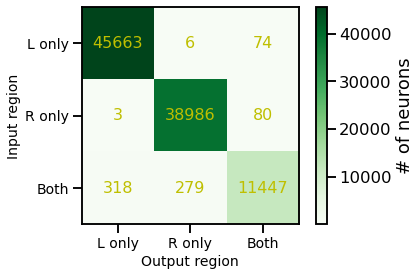

In [82]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
htmap = ax.imshow(hem_cnt, cmap="Greens")
for i in range(3):
    for j in range(3):
        text = ax.text(j, i, "{:.0f}".format(hem_cnt[i, j]),
                       ha="center", va="center", color="y", fontsize=16)
ax.set_xticks(range(3))
ax.set_xticklabels(["L only", "R only", "Both"], fontsize=14)
ax.set_yticks(range(3))
ax.set_yticklabels(["L only", "R only", "Both"], fontsize=14)
ax.set_xlabel("Output region", fontsize=14)
ax.set_ylabel("Input region", fontsize=14)
plt.colorbar(htmap, label="# of neurons")
plt.savefig('figures/stats-{}/hemisphere-specificity.pdf'.format(ver), bbox_inches='tight')
plt.show()

In [74]:
print(vis_link(np.intersect1d(l_only_in_neurons, r_only_out_neurons)))
np.intersect1d(l_only_in_neurons, r_only_out_neurons)

https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22tab%22:%22annotations%22%2C%22selectedAnnotation%22:%7B%22id%22:%22data-bounds%22%7D%2C%22source%22:%22precomputed://https://tigerdata.princeton.edu/sseung-test1/fafb-v15-alignment-temp/fine_final/z0_7063/v1/aligned/mip1%22%2C%22crossSectionRenderScale%22:2%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22MIP1+%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://ng_scratch_ranl_7/ranl/9699b4008aa2af24252ec9db02d60694%22%2C%22type%22:%22segmentation%22%2C%22selectedAlpha%22:0%2C%22saturation%22:0%2C%22objectAlpha%22:0.02%2C%22segmentColors%22:%7B%221%22:%22#b5b5b5%22%7D%2C%22segments%22:%5B%221%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22tissue%22%7D%2C%7B%22source%22:%22graphene://https://prodv1.flywire-daf.com/segmentation/table/fly_v31%22%2C%22type%22:%22segmentation_with_grap

array([720575940616186507, 720575940616450305, 720575940620012253,
       720575940620541823, 720575940621801456, 720575940624006327])

In [75]:
print(vis_link(np.intersect1d(l_only_out_neurons, r_only_in_neurons)))
np.intersect1d(l_only_out_neurons, r_only_in_neurons)

https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22tab%22:%22annotations%22%2C%22selectedAnnotation%22:%7B%22id%22:%22data-bounds%22%7D%2C%22source%22:%22precomputed://https://tigerdata.princeton.edu/sseung-test1/fafb-v15-alignment-temp/fine_final/z0_7063/v1/aligned/mip1%22%2C%22crossSectionRenderScale%22:2%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22MIP1+%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://ng_scratch_ranl_7/ranl/9699b4008aa2af24252ec9db02d60694%22%2C%22type%22:%22segmentation%22%2C%22selectedAlpha%22:0%2C%22saturation%22:0%2C%22objectAlpha%22:0.02%2C%22segmentColors%22:%7B%221%22:%22#b5b5b5%22%7D%2C%22segments%22:%5B%221%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22tissue%22%7D%2C%7B%22source%22:%22graphene://https://prodv1.flywire-daf.com/segmentation/table/fly_v31%22%2C%22type%22:%22segmentation_with_grap

array([720575940614686943, 720575940615526289, 720575940620631974])

In [76]:
none_neurons = np.unique(syn_table[["pre_pt_root_id", "post_pt_root_id"]][syn_table["neuropil"] == 'None']) 
exp_gng_neurons = np.unique(np.concatenate([l_out_neurons, r_out_neurons, l_in_neurons, r_in_neurons, none_neurons]))

In [77]:
hem_cnt.sum(), g.num_vertices(), g.num_vertices() - len(exp_gng_neurons), g.num_vertices() - hem_cnt.sum(), 

(96902, 103515, 2386, 6613)

In [105]:
# what if preserve only strong connections?
def LR_specificity(s_th=1):
    l_out_neurons = np.unique(syn_table["pre_pt_root_id"][syn_table["neuropil"].isin(l_regions) & (syn_table["syn_count"] >=s_th)])
    r_out_neurons = np.unique(syn_table["pre_pt_root_id"][syn_table["neuropil"].isin(r_regions) & (syn_table["syn_count"] >=s_th)])
    l_in_neurons = np.unique(syn_table["post_pt_root_id"][syn_table["neuropil"].isin(l_regions) & (syn_table["syn_count"] >=s_th)])
    r_in_neurons = np.unique(syn_table["post_pt_root_id"][syn_table["neuropil"].isin(r_regions) & (syn_table["syn_count"] >=s_th)])
    lr_out_neurons = np.intersect1d(l_out_neurons, r_out_neurons)
    lr_in_neurons = np.intersect1d(l_in_neurons, r_in_neurons)
    l_only_out_neurons = np.setdiff1d(l_out_neurons, lr_out_neurons)
    l_only_in_neurons = np.setdiff1d(l_in_neurons, lr_in_neurons)
    r_only_out_neurons = np.setdiff1d(r_out_neurons, lr_out_neurons)
    r_only_in_neurons = np.setdiff1d(r_in_neurons, lr_in_neurons)
    
    out_neurons = [l_only_out_neurons, r_only_out_neurons, lr_out_neurons]
    in_neurons = [l_only_in_neurons, r_only_in_neurons, lr_in_neurons]
    hem_cnt = np.array([[len(np.intersect1d(a, b)) for a in out_neurons] for b in in_neurons])
    
    return hem_cnt

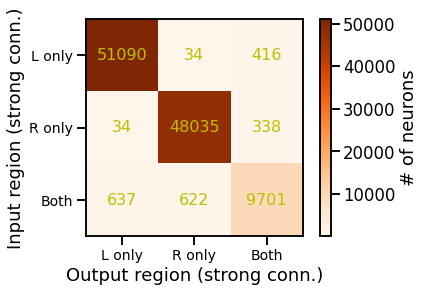

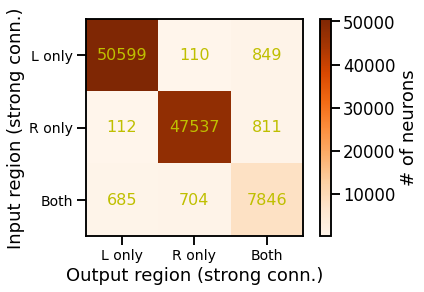

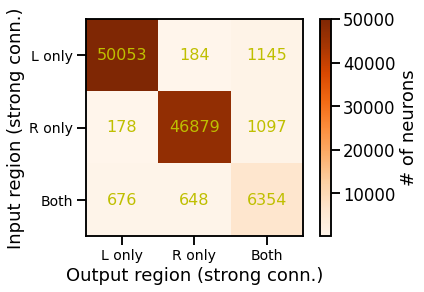

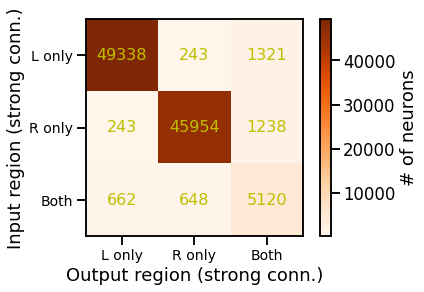

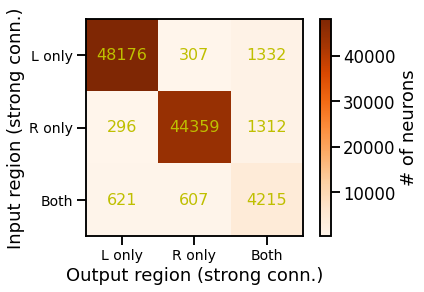

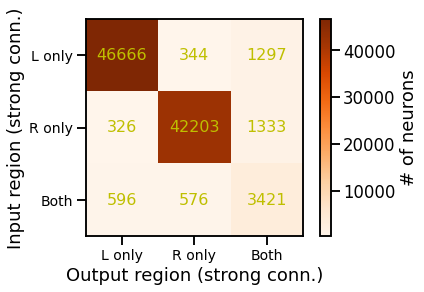

In [106]:
for th in [2,3,4,5,6,7]:
    hem_cnt = LR_specificity(th)
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    htmap = ax.imshow(hem_cnt, cmap="Oranges")
    for i in range(3):
        for j in range(3):
            text = ax.text(j, i, "{:.0f}".format(hem_cnt[i, j]),
                           ha="center", va="center", color="y", fontsize=16)
    ax.set_xticks(range(3))
    ax.set_xticklabels(["L only", "R only", "Both"], fontsize=14)
    ax.set_yticks(range(3))
    ax.set_yticklabels(["L only", "R only", "Both"], fontsize=14)
    ax.set_xlabel("Output region (strong conn.)")
    ax.set_ylabel("Input region (strong conn.)")
    plt.colorbar(htmap, label="# of neurons")
    plt.savefig('figures/stats-{}/hemisphere-specificity-th{}.pdf'.format(ver, th), bbox_inches='tight')
    plt.show()

In [ ]:
%%time
# may take ~ 1min
inter_intra_ratio = []
LR_crossing_ratio = []
for th in range(1,61):
    hem_cnt = LR_specificity(th)
    diag = np.diag(hem_cnt).sum()
    off_diag = hem_cnt.sum() - diag
    LR_cnt = hem_cnt[:2,:2]
    diag_LR = np.diag(LR_cnt).sum()
    off_diag_LR = LR_cnt.sum() - diag_LR
    inter_intra_ratio.append(off_diag / diag)
    LR_crossing_ratio.append(off_diag_LR / diag_LR)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax2 = ax.twinx()
ax.plot(range(1,61), inter_intra_ratio, 'green')
ax2.plot(range(1,61), LR_crossing_ratio, 'orange')
ax.set_ylabel("Off-Diagonal vs Diagonal", color='green')
ax2.set_ylabel("LR Crossing vs LR Specific", color='orange')
ax.set_xlabel("Threshold for # of syn. (≥)")

### 10. Small-wordness

In [48]:
g.clear_filters()

In [17]:
wcc_g = gt.extract_largest_component(g, directed=False)
wcc_g

<GraphView object, directed, with 103459 vertices and 11637285 edges, 1 internal vertex property, 1 internal edge property, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f18eff441d0, at 0x7f18eff651d0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f18eff441d0, at 0x7f18efc78e50>, False), at 0x7f18eff441d0>

In [18]:
scc_g = gt.extract_largest_component(g, directed=True)
scc_g

<GraphView object, directed, with 103034 vertices and 11634344 edges, 1 internal vertex property, 1 internal edge property, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f18eff61450, at 0x7f18efe6fb50>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f18eff61450, at 0x7f18effbcf10>, False), at 0x7f18eff61450>

Average shortest distance (undirected) of ER (https://journals.aps.org/pre/pdf/10.1103/PhysRevE.70.056110)
$$\ell_{ER} = \frac{\ln N - \gamma}{\ln\langle k\rangle} + \frac{1}{2}$$

Average clustering coefficient of ER (undirected) (https://math.stackexchange.com/questions/2641947/expected-global-clustering-coefficient-for-erdős-rényi-graph)
$$\frac{3\binom n3 p^3 - n^{2.5}}{3\binom n3 p^2 + n^{2.5}} \le \frac{X}{Y} \le \frac{3\binom n3 p^3 + n^{2.5}}{3\binom n3 p^2 - n^{2.5}}$$
which means the expectation is roughly $p$.

In [19]:
%%time
# average shortest distance
dist_dir = gt.shortest_distance(scc_g, directed=True)
ave_path_length_dir = sum([sum(i) for i in dist_dir])/(scc_g.num_vertices()**2-scc_g.num_vertices())

CPU times: user 5h 22min 21s, sys: 1min 59s, total: 5h 24min 20s
Wall time: 48min 31s


In [ ]:
%%time
# average shortest distance
dist_undir = gt.shortest_distance(wcc_g, directed=False)
ave_path_length_undir = sum([sum(i) for i in dist_undir])/(wcc_g.num_vertices()**2-wcc_g.num_vertices())

In [ ]:
# the small-worldness (treated as undirected graph)

In [ ]:
ave_path_length_dir

In [ ]:
ave_path_length_undir

In [50]:
%%time
clustering_coef = gt.global_clustering(g)

CPU times: user 1min 31s, sys: 1.25 s, total: 1min 32s
Wall time: 6.32 s


In [69]:
clustering_coef

(0.1204565681083685, 0.0038786072850200627)

In [ ]:
reciprocity = gt.edge_reciprocity(g)

In [ ]:
logk = np.log((g.num_edges() - reciprocity * g.num_edges() / 2) * 2 / g.num_vertices())

In [ ]:
ave_path_length_er = (np.log(g.num_vertices()) - 0.57721) / logk + 0.5

In [ ]:
ave_path_length_er

In [ ]:
p_undir = (g.num_edges() - reciprocity * g.num_edges() / 2) / ((g.num_vertices()-1) * g.num_vertices() / 2)
p_undir

In [ ]:
clustering_coef[0] / p_undir, ave_path_length_undir / ave_path_length_er

In [ ]:
(clustering_coef[0] / p_undir) / (ave_path_length_undir / ave_path_length_er)

In [52]:
cfg = gt.Graph()
cfg.add_vertex(len(cellids))
cfg.add_edge_list(merged_edge_list)

In [ ]:
%%time
# this block takes long time (~25min for 100 samples)
cfg_cls = []
for _ in range(100):
    gt.random_rewire(cfg)
    cfg_cls.append(gt.global_clustering(cfg)[0])

In [ ]:
np.mean(cfg_cls)

In [73]:
p_conn = g.num_edges() / (g.num_vertices() * (g.num_vertices()-1))

In [74]:
clustering_coef[0] / (1-(1-p_conn)**2)

55.426483579506616

In [70]:
clustering_coef[0] / np.mean(cfg_cls)

9.241255105442868

In [ ]:
dist_dir[2].a

In [ ]:
# max_dist_dir = 0
# max_dist_dir_nid = 0
# for nid in scc_g.get_vertices(): 
#     tmp = max(np.max(dist_dir[nid].a), max_dist_dir)
#     if max_dist_dir < tmp:
#         max_dist_dir = tmp
#         max_dist_dir_nid = nid

In [ ]:
max_dist_dir, max_dist_dir_nid

In [ ]:
max_dist_undir = 0
max_dist_undir_nid = 0
for nid in scc_g.get_vertices(): 
    tmp = max(np.max(dist_undir[nid].a), max_dist_undir)
    if max_dist_undir < tmp:
        max_dist_undir = tmp
        max_dist_undir_nid = nid

In [ ]:
max_dist_undir, max_dist_undir_nid

In [ ]:
nid2cid[31881]

In [ ]:
max_dist_dir = 0
max_dist_dir_nid = 0
for nid in scc_g.get_vertices(): 
    tmp = max(np.max(dist_dir[nid].a), max_dist_dir)
    if max_dist_dir < tmp:
        max_dist_dir = tmp
        max_dist_dir_nid = nid

In [ ]:
%%time
from collections import Counter

dist_dir_list = np.array([0,0,0,0,0,0,0,0,0,0,0])
n_scc = scc_g.get_vertices()
for nid in scc_g.get_vertices(): 
        counter = Counter(dist_dir[nid].a[n_scc])
        for i in counter.keys():
            dist_dir_list[i] += counter[i]

In [37]:
dist_dir_list

array([    103034,   11634344, 1075271729, 5941144928, 3445031341,
        139918792,    2744302,     155713,        966,          7,
                0])

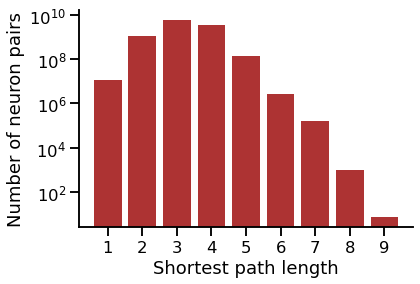

In [35]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.bar(np.arange(10)[1:], dist_dir_list[1:10], color=[0.6,0,0], alpha=0.8)
ax.set_yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(1,10))
ax.set_xlabel('Shortest path length')
ax.set_ylabel('Number of neuron pairs')
plt.savefig('figures/stats-{}/scc-shortest-path.pdf'.format(ver), bbox_inches='tight')

In [ ]:
dist_dir_list

In [ ]:
%%time
from collections import Counter

dist_undir_list = np.array([0,0,0,0,0,0,0,0,0,0,0])
n_wcc = wcc_g.get_vertices()
for nid in wcc_g.get_vertices(): 
        counter = Counter(dist_undir[nid].a[n_wcc])
        for i in counter.keys():
            dist_undir_list[i] += counter[i]

In [ ]:
np.sum(dist_undir_list * np.arange(11)) / (len(n_wcc) * (len(n_wcc) - 1))

In [38]:
dist_undir_list

array([    103459,   20208740, 1947370096, 6856179262, 1864588116,
         15239800,      75138,         70,          0,          0,
                0])

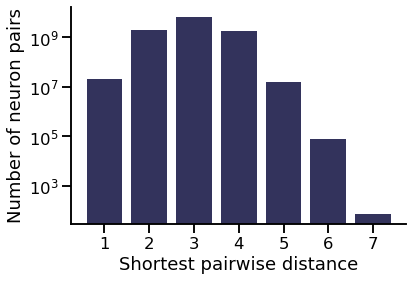

In [39]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.bar(np.arange(8)[1:], dist_undir_list[1:8], color=[0,0,0.2], alpha=0.8)
ax.set_yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(1,8))
ax.set_xlabel('Shortest pairwise distance')
ax.set_ylabel('Number of neuron pairs')
plt.savefig('figures/stats-{}/wcc-shortest-path.pdf'.format(ver), bbox_inches='tight')

### Re-do for truncated graphs

In [78]:
strong_filter = g.new_ep('bool')
for e in g.edges():
    strong_filter[e] = True if g.ep["syn_count"][e] >=5 else False
g.set_edge_filter(strong_filter)
g_th5 = gt.Graph(g, prune=True)

In [79]:
g_th5

<Graph object, directed, with 127319 vertices and 2613129 edges, 1 internal vertex property, 1 internal edge property, at 0x7f80fca542b0>

In [81]:
# bidirectional edges / total edges
reciprocity_th5 = gt.edge_reciprocity(g_th5)
print("edge reciprocity:", reciprocity_th5)

edge reciprocity: 0.13837740119221056


In [82]:
# connection probability
p_conn_th5 = g_th5.num_edges() / (g_th5.num_vertices() * (g_th5.num_vertices()-1))
print("connection probability:", p_conn_th5)

connection probability: 0.00016120474575863678


In [83]:
%%time
clustering_coef_th5 = gt.global_clustering(g_th5)

CPU times: user 18.9 s, sys: 144 ms, total: 19.1 s
Wall time: 1.94 s


In [84]:
clustering_coef_th5

(0.04632866099163119, 0.00732633798037328)

In [85]:
clustering_coef_th5[0] / (1-(1-p_conn_th5)**2)

143.7066733817255

In [86]:
# overrepresentation to ER
(reciprocity_th5 * p_conn_th5) / (p_conn_th5 * p_conn_th5)

858.3953316076415

In [92]:
cfg_th5 = gt.Graph(g_th5)

In [93]:
%%time
# this block takes long time (~15min for 100 samples)
cfg_rec_th5 = []
cfg_cls_th5 = []
for _ in range(100):
    gt.random_rewire(cfg_th5)
    cfg_rec_th5.append(gt.edge_reciprocity(cfg_th5))
    cfg_cls_th5.append(gt.global_clustering(cfg_th5)[0])

CPU times: user 49min 40s, sys: 27.4 s, total: 50min 7s
Wall time: 11min 10s


In [94]:
np.mean(cfg_rec_th5)

0.0031628136230549657

In [95]:
reciprocity_th5 / np.mean(cfg_rec_th5)

43.75136118787539

In [96]:
clustering_coef_th5[0] / np.mean(cfg_cls_th5)

7.567242827868295

In [98]:
# No autapse
np.unique(gt.label_self_loops(g_th5).a)

PropertyArray([0], dtype=int32)

In [99]:
# Strongly Connected Components (SCCs)
sg_cmps, sg_cmp_hist = gt.label_components(g_th5, directed=True)

In [100]:
print("top sizes of SCC:", np.sort(sg_cmp_hist)[::-1][:10])
print("number of SCC:", len(sg_cmp_hist))

top sizes of SCC: [115661      4      4      4      3      3      3      3      3      2]
number of SCC: 11588


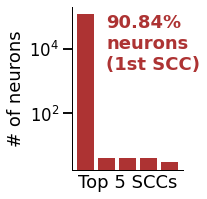

In [101]:
fig, ax = plt.subplots(1,1,figsize=(2, 3))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

ax.bar(np.arange(5),
       np.sort(sg_cmp_hist)[::-1][:5],
       color=[0.6,0,0], alpha=0.8)
ll = np.sort(sg_cmp_hist)[::-1][0]
ax.text(1.0, 0.02*ll, "{:.2f}%\nneurons\n(1st SCC)".format(100*ll/sum(sg_cmp_hist)), 
        color=[0.6,0,0], alpha=0.8, weight='bold')
ax.set_xlabel("Top 5 SCCs")
ax.set_xticks([], [])
ax.set_ylabel('# of neurons')
ax.set_yscale('log')
plt.savefig('figures/stats-{}/scc-dist-th5.pdf'.format(ver), bbox_inches='tight')

In [102]:
# Weakly Connected Components (WCCs)
wg_cmps, wg_cmp_hist = gt.label_components(g, directed=False)

In [103]:
print("top sizes of WCC:", np.sort(wg_cmp_hist)[::-1][:10])
print("number of WCC:", len(wg_cmp_hist))

top sizes of WCC: [124778      7      7      7      7      6      6      5      5      4]
number of WCC: 2463


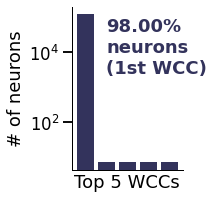

In [104]:
fig, ax = plt.subplots(1,1,figsize=(2, 3))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

ax.bar(np.arange(5),
       np.sort(wg_cmp_hist)[::-1][:5],
       color=[0,0,0.2], alpha=0.8)
ll = np.sort(wg_cmp_hist)[::-1][0]
ax.text(1.0, 0.02*ll, "{:.2f}%\nneurons\n(1st WCC)".format(100*ll/sum(wg_cmp_hist)), 
        color=[0,0,0.2], alpha=0.8, weight='bold')
ax.set_xlabel("Top 5 WCCs")
ax.set_xticks([], [])
ax.set_ylabel('# of neurons')
ax.set_yscale('log')
plt.savefig('figures/stats-{}/wcc-dist-th5.pdf'.format(ver), bbox_inches='tight')

In [18]:
wcc_g_th5 = gt.extract_largest_component(g_th5, directed=False)
wcc_g_th5

<GraphView object, directed, with 124778 vertices and 2613045 edges, 1 internal vertex property, 1 internal edge property, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fd38f377cd0, at 0x7fd055942910>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fd38f377cd0, at 0x7fd3768a50d0>, False), at 0x7fd38f377cd0>

In [19]:
scc_g_th5 = gt.extract_largest_component(g_th5, directed=True)
scc_g_th5

<GraphView object, directed, with 115661 vertices and 2559263 edges, 1 internal vertex property, 1 internal edge property, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fd055942110, at 0x7fd055996450>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fd055942110, at 0x7fd055996350>, False), at 0x7fd055942110>

In [20]:
%%time
# average shortest distance
dist_dir_th5 = gt.shortest_distance(scc_g_th5, directed=True)
ave_path_length_dir_th5 = sum([sum(i) for i in dist_dir_th5])/(scc_g_th5.num_vertices()**2-scc_g_th5.num_vertices())

CPU times: user 2h 13min 23s, sys: 1min 37s, total: 2h 15min
Wall time: 42min 58s


In [ ]:
%%time
# average shortest distance
dist_undir_th5 = gt.shortest_distance(wcc_g_th5, directed=False)
ave_path_length_undir_th5 = sum([sum(i) for i in dist_undir_th5])/(wcc_g_th5.num_vertices()**2-wcc_g_th5.num_vertices())

In [ ]:
%%time
from collections import Counter

dist_dir_list_th5 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0])
n_scc_th5 = scc_g_th5.get_vertices()
for nid in scc_g_th5.get_vertices(): 
        counter = Counter(dist_dir_th5[nid].a[n_scc_th5])
        for i in counter.keys():
            dist_dir_list_th5[i] += counter[i]

In [30]:
dist_dir_list_th5, len(dist_dir_list_th5)

(array([     2589,     56837,   4670662,  37745215, 120131775, 105300472,
         28658335,   2585792,    243328,     41566,      7052,      2183,
              505,        17]),
 14)

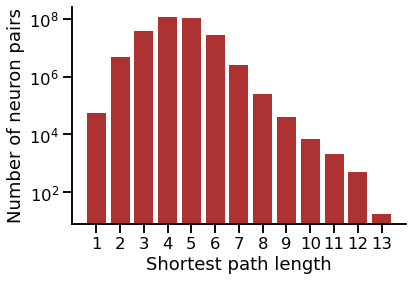

In [32]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.bar(np.arange(14)[1:], dist_dir_list_th5[1:14], color=[0.6,0,0], alpha=0.8)
ax.set_yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(1,14))
ax.set_xlabel('Shortest path length')
ax.set_ylabel('Number of neuron pairs')
plt.savefig('figures/stats-{}/scc-shortest-path-th5.pdf'.format(ver), bbox_inches='tight')

In [ ]:
%%time
from collections import Counter

dist_undir_list_th5 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0])
n_wcc_th5 = wcc_g_th5.get_vertices()
for nid in wcc_g_th5.get_vertices(): 
        counter = Counter(dist_undir_th5[nid].a[n_wcc_th5])
        for i in counter.keys():
            dist_undir_list_th5[i] += counter[i]

In [ ]:
np.sum(dist_undir_list * np.arange(11)) / (len(n_wcc) * (len(n_wcc) - 1))

In [34]:
dist_undir_list_th5, len(dist_undir_list_th5)

(array([    124778,    4864496,  501851650, 4220005324, 7451624480,
        3029706788,  338389286,   22150624,     814308,      17268,
               280,          2,          0,          0]),
 14)

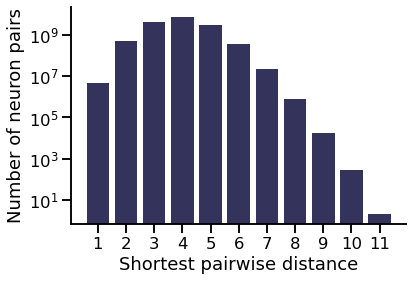

In [35]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.bar(np.arange(12)[1:], dist_undir_list_th5[1:12], color=[0,0,0.2], alpha=0.8)
ax.set_yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(1,12))
ax.set_xlabel('Shortest pairwise distance')
ax.set_ylabel('Number of neuron pairs')
plt.savefig('figures/stats-{}/wcc-shortest-path-th5.pdf'.format(ver), bbox_inches='tight')

### Smallworldness

In [80]:
reciprocity_th5 = gt.edge_reciprocity(g_th5)
logk = np.log((g_th5.num_edges() - reciprocity_th5 * g_th5.num_edges() / 2) * 2 / g_th5.num_vertices())

In [81]:
ave_path_length_er = (np.log(g_th5.num_vertices()) - 0.57721) / logk + 0.5

In [82]:
ave_path_length_er

3.5680944601473077

In [83]:
p_undir = (g_th5.num_edges() - reciprocity_th5 * g_th5.num_edges() / 2) / ((g_th5.num_vertices()-1) * g_th5.num_vertices() / 2)
p_undir

0.0003001023977393424

In [84]:
clustering_coef_th5 = 0.04632866099163119

In [96]:
ave_path_length_undir = ([124778,    4864496,  501851650, 4220005324, 7451624480,
                          3029706788,  338389286,   22150624,     814308,      17268,
                          280,          2,          0,          0] * np.arange(14)).sum() / sum([4864496,  501851650, 4220005324, 7451624480,
                          3029706788,  338389286,   22150624,     814308,      17268,
                          280,          2,          0,          0])

In [97]:
ave_path_length_undir

3.906096746643617

In [99]:
clustering_coef_th5 / p_undir, ave_path_length_undir / ave_path_length_er

(154.3761774001903, 1.0947290746563798)

In [100]:
(clustering_coef_th5 / p_undir) / (ave_path_length_undir / ave_path_length_er)

141.01770106786176

### rich-club w/ threshold

In [101]:
g = g_th5

In [102]:
g

<Graph object, directed, with 127319 vertices and 2613129 edges, 1 internal vertex property, 1 internal edge property, at 0x7f80fca542b0>

In [139]:
vremove = sorted([v for v in g.vertices()], key=lambda v: v.out_degree())
vper_out_degrees = [v.out_degree() for v in vremove]
vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)
np.random.shuffle(vremove)
rand_vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
rand_vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)

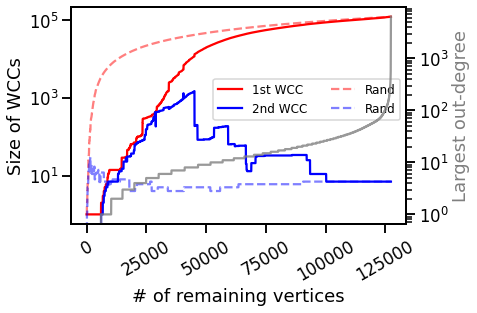

In [141]:
# edge percolation, removing vertices with large out degrees
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(vper_1st_sizes, 'red', label='1st WCC')
ax.plot(vper_2nd_sizes, 'blue', label='2nd WCC')
ax.plot(rand_vper_1st_sizes, 'red', linestyle='--', alpha=0.5, label='Rand')
ax.plot(rand_vper_2nd_sizes, 'blue', linestyle='--', alpha=0.5, label='Rand')
ax2.plot(vper_out_degrees, 'gray', alpha=0.8)
ax.set_ylabel("Size of WCCs")
ax2.set_ylabel("Largest out-degree", color='gray')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining vertices")
ax.tick_params(axis='x', rotation=30)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.45), ncol=2, fontsize=12)
plt.savefig('figures/stats-{}/remove-large-out.pdf'.format(ver), bbox_inches='tight')

In [106]:
vremove = sorted([v for v in g.vertices()], key=lambda v: -v.out_degree())
vper_out_degrees = [v.out_degree() for v in vremove]
vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)
np.random.shuffle(vremove)
rand_vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
rand_vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)

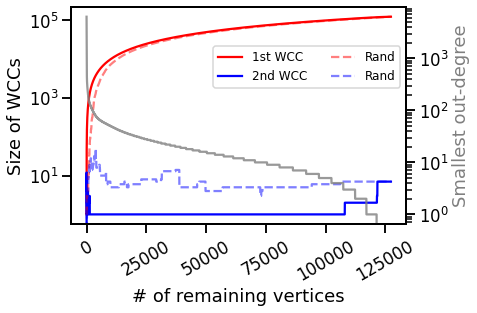

In [107]:
# edge percolation, removing vertices with small out degrees
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(vper_1st_sizes, 'red', label='1st WCC')
ax.plot(vper_2nd_sizes, 'blue', label='2nd WCC')
ax.plot(rand_vper_1st_sizes, 'red', linestyle='--', alpha=0.5, label='Rand')
ax.plot(rand_vper_2nd_sizes, 'blue', linestyle='--', alpha=0.5, label='Rand')
ax2.plot(vper_out_degrees, 'gray', alpha=0.8)
ax.set_ylabel("Size of WCCs")
ax2.set_ylabel("Smallest out-degree", color='gray')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining vertices")
ax.tick_params(axis='x', rotation=30)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.6), ncol=2, fontsize=12)
plt.savefig('figures/stats-{}/remove-small-out.pdf'.format(ver), bbox_inches='tight')

In [142]:
vremove = sorted([v for v in g.vertices()], key=lambda v: v.in_degree())
vper_in_degrees = [v.in_degree() for v in vremove]
vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)
np.random.shuffle(vremove)
rand_vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
rand_vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)

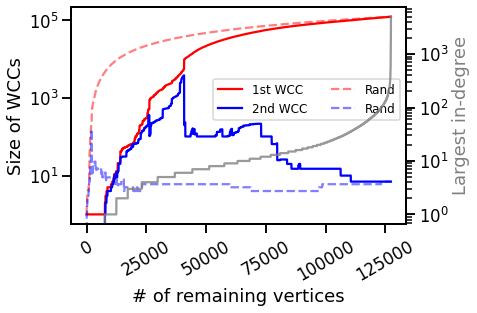

In [143]:
# edge percolation, removing vertices with large out degrees
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(vper_1st_sizes, 'red', label='1st WCC')
ax.plot(vper_2nd_sizes, 'blue', label='2nd WCC')
ax.plot(rand_vper_1st_sizes, 'red', linestyle='--', alpha=0.5, label='Rand')
ax.plot(rand_vper_2nd_sizes, 'blue', linestyle='--', alpha=0.5, label='Rand')
ax2.plot(vper_in_degrees, 'gray', alpha=0.8)
ax.set_ylabel("Size of WCCs")
ax2.set_ylabel("Largest in-degree", color='gray')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining vertices")
ax.tick_params(axis='x', rotation=30)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.45), ncol=2, fontsize=12)
plt.savefig('figures/stats-{}/remove-large-in.pdf'.format(ver), bbox_inches='tight')

In [110]:
vremove = sorted([v for v in g.vertices()], key=lambda v: -v.in_degree())
vper_in_degrees = [v.in_degree() for v in vremove]
vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)
np.random.shuffle(vremove)
rand_vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
rand_vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)

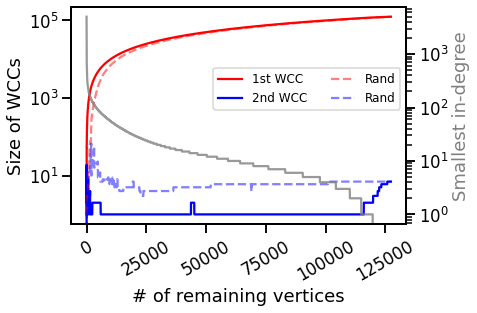

In [111]:
# edge percolation, removing vertices with large out degrees
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(vper_1st_sizes, 'red', label='1st WCC')
ax.plot(vper_2nd_sizes, 'blue', label='2nd WCC')
ax.plot(rand_vper_1st_sizes, 'red', linestyle='--', alpha=0.5, label='Rand')
ax.plot(rand_vper_2nd_sizes, 'blue', linestyle='--', alpha=0.5, label='Rand')
ax2.plot(vper_in_degrees, 'gray', alpha=0.8)
ax.set_ylabel("Size of WCCs")
ax2.set_ylabel("Smallest in-degree", color='gray')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining vertices")
ax.tick_params(axis='x', rotation=30)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.5), ncol=2, fontsize=12)
plt.savefig('figures/stats-{}/remove-small-in.pdf'.format(ver), bbox_inches='tight')

In [144]:
vremove = sorted([v for v in g.vertices()], key=lambda v: v.in_degree() + v.out_degree())
vper_total_degrees = [v.in_degree() + v.out_degree() for v in vremove]
vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)
np.random.shuffle(vremove)
rand_vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
rand_vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)

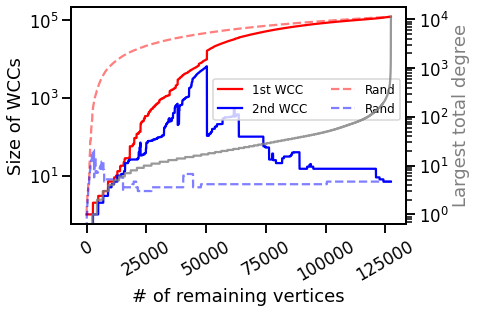

In [145]:
# edge percolation, removing vertices with large out degrees
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(vper_1st_sizes, 'red', label='1st WCC')
ax.plot(vper_2nd_sizes, 'blue', label='2nd WCC')
ax.plot(rand_vper_1st_sizes, 'red', linestyle='--', alpha=0.5, label='Rand')
ax.plot(rand_vper_2nd_sizes, 'blue', linestyle='--', alpha=0.5, label='Rand')
ax2.plot(vper_total_degrees, 'gray', alpha=0.8)
ax.set_ylabel("Size of WCCs")
ax2.set_ylabel("Largest total degree", color='gray')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining vertices")
ax.tick_params(axis='x', rotation=30)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.45), ncol=2, fontsize=12)
plt.savefig('figures/stats-{}/remove-large-total.pdf'.format(ver), bbox_inches='tight')

In [114]:
vremove = sorted([v for v in g.vertices()], key=lambda v: -v.in_degree()-v.out_degree())
vper_total_degrees = [v.in_degree()+v.out_degree() for v in vremove]
vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)
np.random.shuffle(vremove)
rand_vper_1st_sizes, comp = gt.vertex_percolation(g, vremove)
rand_vper_2nd_sizes, comp = gt.vertex_percolation(g, vremove, second=True)

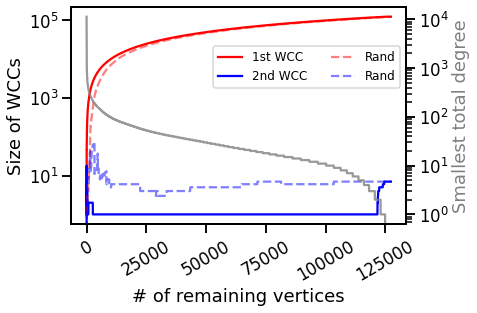

In [115]:
# edge percolation, removing vertices with large out degrees
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()
ax.plot(vper_1st_sizes, 'red', label='1st WCC')
ax.plot(vper_2nd_sizes, 'blue', label='2nd WCC')
ax.plot(rand_vper_1st_sizes, 'red', linestyle='--', alpha=0.5, label='Rand')
ax.plot(rand_vper_2nd_sizes, 'blue', linestyle='--', alpha=0.5, label='Rand')
ax2.plot(vper_total_degrees, 'gray', alpha=0.8)
ax.set_ylabel("Size of WCCs")
ax2.set_ylabel("Smallest total degree", color='gray')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xlabel("# of remaining vertices")
ax.tick_params(axis='x', rotation=30)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.6), ncol=2, fontsize=12)
plt.savefig('figures/stats-{}/remove-small-total.pdf'.format(ver), bbox_inches='tight')

### 5.6 Smilkov & Kocarev - directed rich club

In [116]:
rich_club_coefficients = {}
rich_club_coefficients_null = {}

In [ ]:
%%time
degrees = g.degree_property_map("in") 

# Compute the maximum degree in the graph
max_degree = int(np.max(degrees.a))

# Create a list to store the rich club coefficients
rich_club_coefficients["in"] = []

# Compute the rich club coefficients for each value of k
for k in range(1, max_degree + 1):
    subgraph = gt.GraphView(g, vfilt=(degrees.a >= k))
    m = subgraph.num_edges()
    nk = subgraph.num_vertices()
    if m > 0:
        k_edges = (nk * (nk - 1))
        rich_club_coefficients["in"].append(m / k_edges)
    else:
        rich_club_coefficients["in"].append(0)

In [ ]:
rich_club_coefficients_nulls.keys()

In [16]:
rich_club_coefficients_nulls = {}

In [127]:
rich_club_coefficients_nulls["in"] = []

In [128]:
%%time
# Generate a random null model for each value of k

g_rand = gt.Graph(g)
for repeat in range(5):
    res = []
    ret = gt.random_rewire(g_rand, "configuration", n_iter=10)
    in_degrees = g_rand.degree_property_map("in")  
    max_degree = int(np.max(in_degrees.a))

    for k in range(1, max_degree + 1):
        subgraph = gt.GraphView(g_rand, vfilt=(in_degrees.a >= k))
        m_rand = subgraph.num_edges()
        if m_rand > 0:
            nk = subgraph.num_vertices()
            if m_rand > 0:
                k_edges_rand = (nk * (nk - 1))
                res.append(m_rand / k_edges_rand)
            else:
                res.append(0)
        else:
            res.append(0)
            
    rich_club_coefficients_nulls["in"].append(res)

CPU times: user 8min 16s, sys: 7.16 s, total: 8min 23s
Wall time: 8min 22s


In [129]:
import pickle

with open('saved/630-rich-club-in-cfg.pickle', 'wb') as handle:
    pickle.dump(rich_club_coefficients_nulls["in"], handle, protocol=pickle.HIGHEST_PROTOCOL)

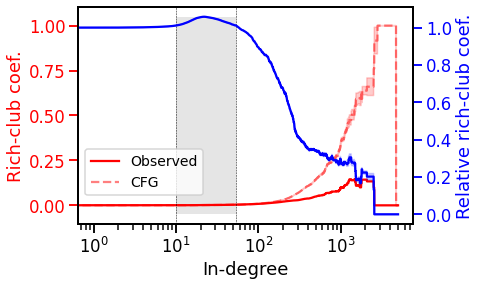

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(rich_club_coefficients["in"], color='red', label="Observed")
ax.plot(np.mean(rich_club_coefficients_nulls["in"], axis=0), linestyle="--", color='red', alpha=0.5, label="CFG")

# Calculate mean and standard deviation
mean = np.mean(rich_club_coefficients_nulls["in"], axis=0)
std = np.std(rich_club_coefficients_nulls["in"], axis=0)

# Plot mean with shadow
ax.fill_between(range(len(mean)), mean - std, mean + std, color='red', alpha=0.2)

ax.set_xlabel("In-degree")
ax.set_xscale('log')
ax.tick_params(axis='y', colors='red')
ax.set_ylabel("Rich-club coef.", color='red')
plt.legend(loc="lower left", bbox_to_anchor=(0.0, 0.1), fontsize=14)

ax2 = ax.twinx()

# Calculate relative rich-club coefficients with standard deviation
relative_rc = np.divide(np.array(rich_club_coefficients["in"]), mean, out=np.zeros_like(mean), where=mean != 0)
relative_rc_std = np.std([np.divide(np.array(rich_club_coefficients["in"]), rich_club_coefficients_nulls["in"][i], 
                      out=np.zeros_like(mean), where=mean != 0) for i in range(5)], axis=0)

ax2.plot(relative_rc, color='blue')
ax2.fill_between(range(len(relative_rc)), relative_rc - relative_rc_std, relative_rc + relative_rc_std, color='blue', alpha=0.2)

ax2.tick_params(axis='y', colors='blue')
ax2.set_ylabel("Relative rich-club coef.", color='blue')

# Add vertical dashed lines where relative_rc > 1
sig_range = np.arange(len(relative_rc))[relative_rc > 1.01]
ax.axvline(sig_range.min(), color='black', linestyle='--', linewidth=0.5)
ax.axvline(sig_range.max(), color='black', linestyle='--', linewidth=0.5)

# Fill the region between the vertical lines with transparent gray
ax.fill_betweenx(ax.get_ylim(), sig_range.min(), sig_range.max(), facecolor='gray', alpha=0.2, edgecolor=None)

plt.savefig('figures/stats-{}/rich-club-in-arbitary-th5.pdf'.format(ver), bbox_inches='tight')

In [147]:
sig_range

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54])

In [148]:
%%time
degrees = g.degree_property_map("out") 

# Compute the maximum degree in the graph
max_degree = int(np.max(degrees.a))

# Create a list to store the rich club coefficients
rich_club_coefficients["out"] = []

# Compute the rich club coefficients for each value of k
for k in range(1, max_degree + 1):
    subgraph = gt.GraphView(g, vfilt=(degrees.a >= k))
    m = subgraph.num_edges()
    nk = subgraph.num_vertices()
    if m > 0:
        k_edges = (nk * (nk - 1))
        rich_club_coefficients["out"].append(m / k_edges)
    else:
        rich_club_coefficients["out"].append(0)

CPU times: user 2min 27s, sys: 4 ms, total: 2min 27s
Wall time: 2min 27s


In [149]:
rich_club_coefficients_nulls["out"] = []

In [150]:
%%time
# Generate a random null model for each value of k

g_rand = gt.Graph(g)
for repeat in range(5):
    res = []
    ret = gt.random_rewire(g_rand, "configuration", n_iter=10)
    out_degrees = g_rand.degree_property_map("out")  
    max_degree = int(np.max(out_degrees.a))

    for k in range(1, max_degree + 1):
        subgraph = gt.GraphView(g_rand, vfilt=(out_degrees.a >= k))
        m_rand = subgraph.num_edges()
        if m_rand > 0:
            nk = subgraph.num_vertices()
            if m_rand > 0:
                k_edges_rand = (nk * (nk - 1))
                res.append(m_rand / k_edges_rand)
            else:
                res.append(0)
        else:
            res.append(0)
            
    rich_club_coefficients_nulls["out"].append(res)

CPU times: user 11min 58s, sys: 4.13 s, total: 12min 2s
Wall time: 12min


In [151]:
import pickle

with open('saved/630-rich-club-out-cfg.pickle', 'wb') as handle:
    pickle.dump(rich_club_coefficients_nulls["out"], handle, protocol=pickle.HIGHEST_PROTOCOL)

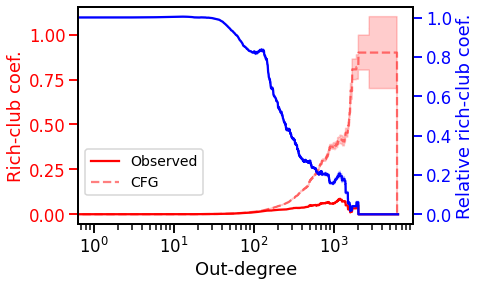

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(rich_club_coefficients["out"], color='red', label="Observed")
ax.plot(np.mean(rich_club_coefficients_nulls["out"], axis=0), linestyle="--", color='red', alpha=0.5, label="CFG")

# Calculate mean and standard deviation
mean = np.mean(rich_club_coefficients_nulls["out"], axis=0)
std = np.std(rich_club_coefficients_nulls["out"], axis=0)

# Plot mean with shadow
ax.fill_between(range(len(mean)), mean - std, mean + std, color='red', alpha=0.2)

ax.set_xlabel("Out-degree")
ax.set_xscale('log')
ax.tick_params(axis='y', colors='red')
ax.set_ylabel("Rich-club coef.", color='red')
plt.legend(loc="lower left", bbox_to_anchor=(0.0, 0.1), fontsize=14)

ax2 = ax.twinx()

# Calculate relative rich-club coefficients with standard deviation
relative_rc = np.divide(np.array(rich_club_coefficients["out"]), mean, out=np.zeros_like(mean), where=mean != 0)
relative_rc_std = np.std([np.divide(np.array(rich_club_coefficients["out"]), rich_club_coefficients_nulls["out"][i], 
                      out=np.zeros_like(mean), where=mean != 0) for i in range(5)], axis=0)

ax2.plot(relative_rc, color='blue')
ax2.fill_between(range(len(relative_rc)), relative_rc - relative_rc_std, relative_rc + relative_rc_std, color='blue', alpha=0.2)

ax2.tick_params(axis='y', colors='blue')
ax2.set_ylabel("Relative rich-club coef.", color='blue')

# Add vertical dashed lines where relative_rc > 1
# sig_range = np.arange(len(relative_rc))[relative_rc > 1.01]
# ax.axvline(sig_range.min(), color='black', linestyle='--', linewidth=0.5)
# ax.axvline(sig_range.max(), color='black', linestyle='--', linewidth=0.5)

# Fill the region between the vertical lines with transparent gray
# ax.fill_betweenx(ax.get_ylim(), sig_range.min(), sig_range.max(), facecolor='gray', alpha=0.2, edgecolor=None)

plt.savefig('figures/stats-{}/rich-club-out-arbitary-th5.pdf'.format(ver), bbox_inches='tight')

In [ ]:
sig_range

In [117]:
%%time
in_degrees = g.degree_property_map("in") 
out_degrees = g.degree_property_map("out") 

# Compute the maximum degree in the graph
max_degree = int(np.max(in_degrees.a + out_degrees.a))

# Create a list to store the rich club coefficients
rich_club_coefficients["total"] = []

# Compute the rich club coefficients for each value of k
for k in range(1, max_degree + 1):
    subgraph = gt.GraphView(g, vfilt=(in_degrees.a + out_degrees.a >= k))
    m = subgraph.num_edges()
    nk = subgraph.num_vertices()
    if m > 0:
        k_edges = (nk * (nk - 1))
        rich_club_coefficients["total"].append(m / k_edges)
    else:
        rich_club_coefficients["total"].append(0)

CPU times: user 4min 27s, sys: 12 ms, total: 4min 27s
Wall time: 4min 27s


In [118]:
with open('saved/630-rich-club-total-abs.pickle', 'wb') as handle:
    pickle.dump(rich_club_coefficients["total"], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [119]:
rich_club_coefficients_nulls = {}

In [120]:
rich_club_coefficients_nulls["total"] = []

In [121]:
%%time
# Generate a random null model for each value of k

g_rand = gt.Graph(g)
for repeat in range(5):
    res = []
    ret = gt.random_rewire(g_rand, "configuration", n_iter=10)
    in_degrees = g_rand.degree_property_map("in") 
    out_degrees = g_rand.degree_property_map("out") 
    max_degree = int(np.max(in_degrees.a + out_degrees.a))

    for k in range(1, max_degree + 1):
        subgraph = gt.GraphView(g_rand, vfilt=(in_degrees.a + out_degrees.a >= k))
        m_rand = subgraph.num_edges()
        if m_rand > 0:
            nk = subgraph.num_vertices()
            if m_rand > 0:
                k_edges_rand = (nk * (nk - 1))
                res.append(m_rand / k_edges_rand)
            else:
                res.append(0)
        else:
            res.append(0)
            
    rich_club_coefficients_nulls["total"].append(res)

CPU times: user 18min 26s, sys: 4.62 s, total: 18min 31s
Wall time: 18min 34s


In [122]:
with open('saved/630-rich-club-total-cfg.pickle', 'wb') as handle:
    pickle.dump(rich_club_coefficients_nulls["total"], handle, protocol=pickle.HIGHEST_PROTOCOL)

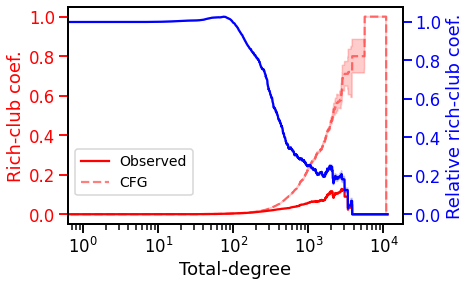

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(rich_club_coefficients["total"], color='red', label="Observed")
ax.plot(np.mean(rich_club_coefficients_nulls["total"], axis=0), linestyle="--", color='red', alpha=0.5, label="CFG")

# Calculate mean and standard deviation
mean = np.mean(rich_club_coefficients_nulls["total"], axis=0)
std = np.std(rich_club_coefficients_nulls["total"], axis=0)

# Plot mean with shadow
ax.fill_between(range(len(mean)), mean - std, mean + std, color='red', alpha=0.2)

ax.set_xlabel("Total-degree")
ax.set_xscale('log')
ax.tick_params(axis='y', colors='red')
ax.set_ylabel("Rich-club coef.", color='red')
plt.legend(loc="lower left", bbox_to_anchor=(0.0, 0.1), fontsize=14)

ax2 = ax.twinx()

# Calculate relative rich-club coefficients with standard deviation
relative_rc = np.divide(np.array(rich_club_coefficients["total"]), mean, out=np.zeros_like(mean), where=mean != 0)
relative_rc_std = np.std([np.divide(np.array(rich_club_coefficients["total"]), rich_club_coefficients_nulls["total"][i], 
                      out=np.zeros_like(mean), where=mean != 0) for i in range(5)], axis=0)

ax2.plot(relative_rc, color='blue')
ax2.fill_between(range(len(relative_rc)), relative_rc - relative_rc_std, relative_rc + relative_rc_std, color='blue', alpha=0.2)

ax2.tick_params(axis='y', colors='blue')
ax2.set_ylabel("Relative rich-club coef.", color='blue')

# Add vertical dashed lines where relative_rc > 1
for i, rc_value in enumerate(relative_rc-10*relative_rc_std > 1):
    if rc_value > 1:
        ax.axvline(i, color='black', linestyle='--', linewidth=0.5)
        break

plt.savefig('figures/stats-{}/rich-club-total-th5.pdf'.format(ver), bbox_inches='tight')

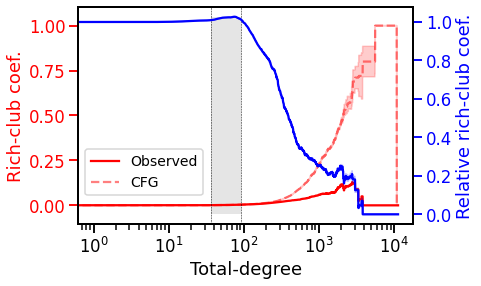

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(rich_club_coefficients["total"], color='red', label="Observed")
ax.plot(np.mean(rich_club_coefficients_nulls["total"], axis=0), linestyle="--", color='red', alpha=0.5, label="CFG")

# Calculate mean and standard deviation
mean = np.mean(rich_club_coefficients_nulls["total"], axis=0)
std = np.std(rich_club_coefficients_nulls["total"], axis=0)

# Plot mean with shadow
ax.fill_between(range(len(mean)), mean - std, mean + std, color='red', alpha=0.2)

ax.set_xlabel("Total-degree")
ax.set_xscale('log')
ax.tick_params(axis='y', colors='red')
ax.set_ylabel("Rich-club coef.", color='red')
plt.legend(loc="lower left", bbox_to_anchor=(0.0, 0.1), fontsize=14)

ax2 = ax.twinx()

# Calculate relative rich-club coefficients with standard deviation
relative_rc = np.divide(np.array(rich_club_coefficients["total"]), mean, out=np.zeros_like(mean), where=mean != 0)
relative_rc_std = np.std([np.divide(np.array(rich_club_coefficients["total"]), rich_club_coefficients_nulls["total"][i], 
                      out=np.zeros_like(mean), where=mean != 0) for i in range(5)], axis=0)

ax2.plot(relative_rc, color='blue')
ax2.fill_between(range(len(relative_rc)), relative_rc - relative_rc_std, relative_rc + relative_rc_std, color='blue', alpha=0.2)

ax2.tick_params(axis='y', colors='blue')
ax2.set_ylabel("Relative rich-club coef.", color='blue')

# Add vertical dashed lines where relative_rc > 1
sig_range = np.arange(len(relative_rc))[relative_rc > 1.01]
ax.axvline(sig_range.min(), color='black', linestyle='--', linewidth=0.5)
ax.axvline(sig_range.max(), color='black', linestyle='--', linewidth=0.5)

# Fill the region between the vertical lines with transparent gray
ax.fill_betweenx(ax.get_ylim(), sig_range.min(), sig_range.max(), facecolor='gray', alpha=0.2, edgecolor=None)

plt.savefig('figures/stats-{}/rich-club-total-arbitary-th5.pdf'.format(ver), bbox_inches='tight')

In [125]:
sig_range.min(), sig_range.max()

(37, 93)

In [126]:
gt.GraphView(g, vfilt=(in_degrees.a + out_degrees.a >= 37))

<GraphView object, directed, with 40218 vertices and 1406674 edges, 1 internal vertex property, 1 internal edge property, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f83ce971cf8, at 0x7f811870a2b0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f83ce971cf8, at 0x7f83d8e6c7b8>, False), at 0x7f83ce971cf8>

In [161]:
np.mean(g.get_total_degrees(g.get_vertices())),np.mean(g.get_in_degrees(g.get_vertices())),np.mean(g.get_out_degrees(g.get_vertices()))

(41.04853164099624, 20.52426582049812, 20.52426582049812)